# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle
import random
from random import sample

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/ex20/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
#train_features = ext_data['train']['features']

In [10]:
#train_features.shape

## training

In [11]:
def random_feature_selection(x, t_d=3776, d=2048):
    idx = torch.tensor(sample(range(0, t_d), d)) # t_d(特徴量)の中からランダムにd個サンプリングする(ぜんぶやると重いから) # わからん
    # 0~t_d idxの中からランダムにd個サンプリングする
    x = np.take(x, idx, 1)
    return x

In [12]:
#ext_data['train'].keys()

In [13]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    #for machine in machine_types:
    #    if machine_type == machine:
    #        ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine}_features.pkl')
    #    else:
    #        ext_data_ = pd.read_pickle(f'{INPUT_ROOT}/{machine}_features.pkl')
    #        ext_data['train']['features'] = np.concatenate([ext_data['train']['features'],
    #                                                        ext_data_['train']['features']], axis=0)
    #        ext_data['train']['labels'] = np.concatenate([ext_data['train']['labels'],
    #                                                     ext_data_['train']['labels']], axis=0)
    #        ext_data['train']['wav_names'] = np.concatenate([ext_data['train']['wav_names'],
    #                                                         ext_data_['train']['wav_names']], axis=0)
            
    #t_d = 3776    # 全特徴量数
    #d = 1024      # 使う特徴量数
    #for phase in ['train', 'valid_source', 'valid_target']:
    #    x = ext_data[phase]['features']
    #    x = random_feature_selection(x)
    #    ext_data[phase]['features'] = x
    #    x = ext_data[phase]['features'][:,512:2048]
    #    ext_data[phase]['features'] = x
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [14]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

2021-06-01 14:09:52,904 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-06-01 14:09:52,905 - 00_train.py - INFO - MAKE DATA_LOADER
2021-06-01 14:09:55,174 - 00_train.py - INFO - TRAINING
2021-06-01 14:09:59,633 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00,  8.13it/s]
2021-06-01 14:10:01,113 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 63.28it/s]
2021-06-01 14:10:01,181 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.47it/s]


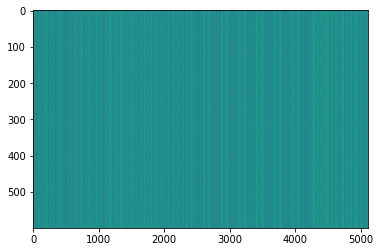

,AUC,pAUC
Source_0,0.640600,0.574211
Source_1,0.478400,0.504737
Source_2,0.631100,0.600526
Target_0,0.650100,0.625789
Target_1,0.605400,0.486316
Target_2,0.604200,0.513684
mean,0.601633,0.550877
h_mean,0.595180,0.546004


2021-06-01 14:10:04,095 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:2466.646698, val_AUC_hmean:0.595180, val_pAUC_hmean:0.546004, best_flag:True
2021-06-01 14:10:04,096 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.19it/s]
2021-06-01 14:10:05,172 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 30.99it/s]
2021-06-01 14:10:05,272 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.75it/s]
2021-06-01 14:10:05,340 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1551.381073, val_AUC_hmean:0.590179, val_pAUC_hmean:0.540900, best_flag:False
2021-06-01 14:10:05,341 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.77it/s]
2021-06-01 14:10:06,458 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.91it/s]
2021-06-01 14:10:06,524 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.46it/s]
2021-06-01 14:10:

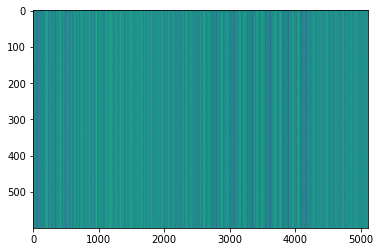

,AUC,pAUC
Source_0,0.706000,0.567368
Source_1,0.602900,0.506842
Source_2,0.781500,0.601579
Target_0,0.732500,0.595789
Target_1,0.595600,0.518421
Target_2,0.574500,0.505789
mean,0.665500,0.549298
h_mean,0.656492,0.546334


2021-06-01 14:10:10,638 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:1111.234222, val_AUC_hmean:0.656492, val_pAUC_hmean:0.546334, best_flag:True
2021-06-01 14:10:10,639 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.46it/s]
2021-06-01 14:10:11,789 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.01it/s]
2021-06-01 14:10:11,852 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.98it/s]


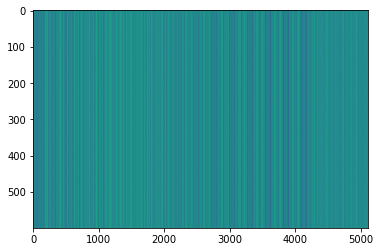

,AUC,pAUC
Source_0,0.762000,0.577895
Source_1,0.619900,0.513158
Source_2,0.795700,0.634211
Target_0,0.711500,0.600526
Target_1,0.563500,0.505263
Target_2,0.637300,0.511579
mean,0.681650,0.557105
h_mean,0.671781,0.552740


2021-06-01 14:10:15,098 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:1033.902995, val_AUC_hmean:0.671781, val_pAUC_hmean:0.552740, best_flag:True
2021-06-01 14:10:15,098 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.38it/s]
2021-06-01 14:10:16,155 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 53.19it/s]
2021-06-01 14:10:16,229 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 31.31it/s]
2021-06-01 14:10:16,322 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:985.905095, val_AUC_hmean:0.645804, val_pAUC_hmean:0.550033, best_flag:False
2021-06-01 14:10:16,323 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.50it/s]
2021-06-01 14:10:17,369 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.27it/s]
2021-06-01 14:10:17,428 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 42.68it/s]


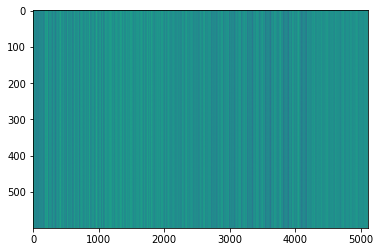

,AUC,pAUC
Source_0,0.745900,0.584211
Source_1,0.630100,0.515789
Source_2,0.811900,0.690000
Target_0,0.734500,0.624211
Target_1,0.587800,0.510000
Target_2,0.652700,0.515789
mean,0.693817,0.573333
h_mean,0.685384,0.565966


2021-06-01 14:10:20,434 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:952.992793, val_AUC_hmean:0.685384, val_pAUC_hmean:0.565966, best_flag:True
2021-06-01 14:10:20,435 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.12it/s]
2021-06-01 14:10:21,516 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 52.61it/s]
2021-06-01 14:10:21,587 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.78it/s]


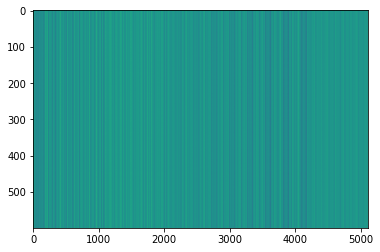

,AUC,pAUC
Source_0,0.743900,0.584211
Source_1,0.660650,0.518421
Source_2,0.842000,0.693684
Target_0,0.764300,0.634737
Target_1,0.608300,0.517368
Target_2,0.630700,0.508421
mean,0.708308,0.576140
h_mean,0.699021,0.568321


2021-06-01 14:10:24,399 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:919.535222, val_AUC_hmean:0.699021, val_pAUC_hmean:0.568321, best_flag:True
2021-06-01 14:10:24,400 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.19it/s]
2021-06-01 14:10:25,476 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.57it/s]
2021-06-01 14:10:25,538 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.06it/s]
2021-06-01 14:10:25,602 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:901.334534, val_AUC_hmean:0.691585, val_pAUC_hmean:0.565539, best_flag:False
2021-06-01 14:10:25,603 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.56it/s]
2021-06-01 14:10:26,643 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.61it/s]
2021-06-01 14:10:26,705 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.16it/s]


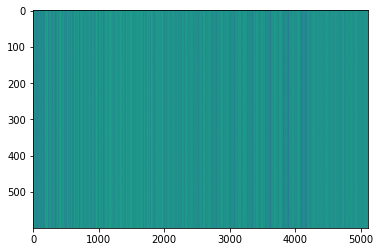

,AUC,pAUC
Source_0,0.760200,0.593158
Source_1,0.635000,0.517895
Source_2,0.847200,0.715263
Target_0,0.757400,0.620000
Target_1,0.618900,0.543684
Target_2,0.591200,0.500526
mean,0.701650,0.581754
h_mean,0.689801,0.573341


2021-06-01 14:10:29,639 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:875.439229, val_AUC_hmean:0.689801, val_pAUC_hmean:0.573341, best_flag:True
2021-06-01 14:10:29,640 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.31it/s]
2021-06-01 14:10:30,704 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.77it/s]
2021-06-01 14:10:30,768 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.89it/s]
2021-06-01 14:10:30,839 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:857.030904, val_AUC_hmean:0.698413, val_pAUC_hmean:0.569788, best_flag:False
2021-06-01 14:10:30,841 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.58it/s]
2021-06-01 14:10:31,878 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.29it/s]
2021-06-01 14:10:31,941 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.21it/s]


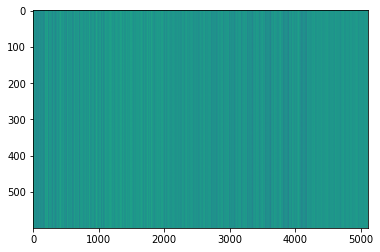

,AUC,pAUC
Source_0,0.753200,0.620526
Source_1,0.692900,0.526316
Source_2,0.816200,0.713684
Target_0,0.750100,0.652105
Target_1,0.632700,0.556316
Target_2,0.651600,0.508947
mean,0.716117,0.596316
h_mean,0.710527,0.587740


2021-06-01 14:10:34,793 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:839.549942, val_AUC_hmean:0.710527, val_pAUC_hmean:0.587740, best_flag:True
2021-06-01 14:10:34,794 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.29it/s]
2021-06-01 14:10:35,860 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.94it/s]
2021-06-01 14:10:35,917 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.22it/s]
2021-06-01 14:10:35,997 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:830.549749, val_AUC_hmean:0.693233, val_pAUC_hmean:0.574385, best_flag:False
2021-06-01 14:10:35,999 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.36it/s]
2021-06-01 14:10:37,056 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 53.80it/s]
2021-06-01 14:10:37,120 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.21it/s]
2021-06-01 14:10:

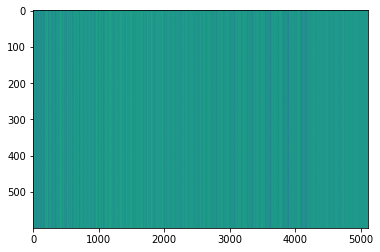

,AUC,pAUC
Source_0,0.766700,0.612632
Source_1,0.672700,0.518947
Source_2,0.841600,0.696316
Target_0,0.796200,0.689474
Target_1,0.675000,0.611053
Target_2,0.617600,0.502632
mean,0.728300,0.605175
h_mean,0.719798,0.595720


2021-06-01 14:10:41,119 - pytorch_modeler.py - INFO - epoch:15/100, train_losses:805.558212, val_AUC_hmean:0.719798, val_pAUC_hmean:0.595720, best_flag:True
2021-06-01 14:10:41,120 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.26it/s]
2021-06-01 14:10:42,189 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.01it/s]
2021-06-01 14:10:42,242 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.99it/s]
2021-06-01 14:10:42,307 - pytorch_modeler.py - INFO - epoch:16/100, train_losses:792.311539, val_AUC_hmean:0.684793, val_pAUC_hmean:0.570754, best_flag:False
2021-06-01 14:10:42,308 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.56it/s]
2021-06-01 14:10:43,349 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.26it/s]
2021-06-01 14:10:43,410 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.03it/s]
2021-06-01 14:10:

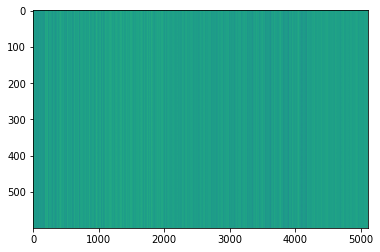

,AUC,pAUC
Source_0,0.763900,0.634211
Source_1,0.695900,0.536316
Source_2,0.838000,0.719474
Target_0,0.775600,0.689474
Target_1,0.664900,0.568947
Target_2,0.630900,0.516842
mean,0.728200,0.610877
h_mean,0.721351,0.601559


2021-06-01 14:10:58,209 - pytorch_modeler.py - INFO - epoch:27/100, train_losses:704.136007, val_AUC_hmean:0.721351, val_pAUC_hmean:0.601559, best_flag:True
2021-06-01 14:10:58,209 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00,  9.97it/s]
2021-06-01 14:10:59,415 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.35it/s]
2021-06-01 14:10:59,472 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.84it/s]
2021-06-01 14:10:59,533 - pytorch_modeler.py - INFO - epoch:28/100, train_losses:698.377711, val_AUC_hmean:0.724660, val_pAUC_hmean:0.593368, best_flag:False
2021-06-01 14:10:59,534 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.53it/s]
2021-06-01 14:11:00,577 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.21it/s]
2021-06-01 14:11:00,633 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.12it/s]
2021-06-01 14:11:

100%|██████████| 2/2 [00:00<00:00, 56.83it/s]
2021-06-01 14:11:18,549 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.80it/s]
2021-06-01 14:11:18,611 - pytorch_modeler.py - INFO - epoch:44/100, train_losses:612.934275, val_AUC_hmean:0.714536, val_pAUC_hmean:0.591823, best_flag:False
2021-06-01 14:11:18,612 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.04it/s]
2021-06-01 14:11:19,701 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 50.02it/s]
2021-06-01 14:11:19,768 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.72it/s]
2021-06-01 14:11:19,834 - pytorch_modeler.py - INFO - epoch:45/100, train_losses:605.802022, val_AUC_hmean:0.718092, val_pAUC_hmean:0.587744, best_flag:False
2021-06-01 14:11:19,835 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.92it/s]
2021-06-01 14:11:20,936 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:01<00:00, 11.69it/s]
2021-06-01 14:11:39,174 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 52.97it/s]
2021-06-01 14:11:39,236 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.82it/s]
2021-06-01 14:11:39,300 - pytorch_modeler.py - INFO - epoch:61/100, train_losses:536.598612, val_AUC_hmean:0.701718, val_pAUC_hmean:0.583218, best_flag:False
2021-06-01 14:11:39,301 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.58it/s]
2021-06-01 14:11:40,340 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.66it/s]
2021-06-01 14:11:40,398 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.69it/s]
2021-06-01 14:11:40,460 - pytorch_modeler.py - INFO - epoch:62/100, train_losses:534.234197, val_AUC_hmean:0.702701, val_pAUC_hmean:0.584183, best_flag:False
2021-06-01 14:11:40,461 - pytorch_modeler.py - INFO - train
100%|██████████|

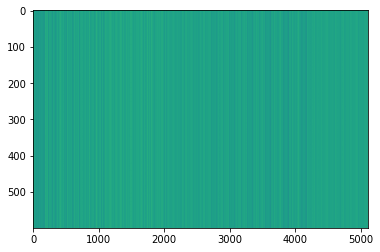

,AUC,pAUC
Source_0,0.783800,0.630526
Source_1,0.653300,0.527368
Source_2,0.843800,0.737368
Target_0,0.780000,0.671579
Target_1,0.678300,0.596842
Target_2,0.590200,0.511579
mean,0.721567,0.612544
h_mean,0.710706,0.602555


2021-06-01 14:11:53,660 - pytorch_modeler.py - INFO - epoch:71/100, train_losses:500.244542, val_AUC_hmean:0.710706, val_pAUC_hmean:0.602555, best_flag:True
2021-06-01 14:11:53,661 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.23it/s]
2021-06-01 14:11:54,732 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.54it/s]
2021-06-01 14:11:54,783 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.56it/s]
2021-06-01 14:11:54,848 - pytorch_modeler.py - INFO - epoch:72/100, train_losses:496.596153, val_AUC_hmean:0.689510, val_pAUC_hmean:0.587365, best_flag:False
2021-06-01 14:11:54,849 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.71it/s]
2021-06-01 14:11:55,876 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.16it/s]
2021-06-01 14:11:55,936 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 49.19it/s]
2021-06-01 14:11:

100%|██████████| 2/2 [00:00<00:00, 57.94it/s]
2021-06-01 14:12:13,388 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.02it/s]
2021-06-01 14:12:13,451 - pytorch_modeler.py - INFO - epoch:88/100, train_losses:440.273379, val_AUC_hmean:0.701573, val_pAUC_hmean:0.588174, best_flag:False
2021-06-01 14:12:13,452 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.55it/s]
2021-06-01 14:12:14,493 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 54.63it/s]
2021-06-01 14:12:14,556 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.52it/s]
2021-06-01 14:12:14,620 - pytorch_modeler.py - INFO - epoch:89/100, train_losses:437.004405, val_AUC_hmean:0.705968, val_pAUC_hmean:0.588465, best_flag:False
2021-06-01 14:12:14,621 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.02it/s]
2021-06-01 14:12:15,713 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

,AUC,pAUC
Source_0,0.783800,0.630526
Source_1,0.653300,0.527368
Source_2,0.843800,0.737368
Target_0,0.780000,0.671579
Target_1,0.678300,0.596842
Target_2,0.590200,0.511579
mean,0.721567,0.612544
h_mean,0.710706,0.602555


2021-06-01 14:12:28,203 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-06-01 14:12:28,204 - 00_train.py - INFO - MAKE DATA_LOADER
2021-06-01 14:12:28,206 - 00_train.py - INFO - TRAINING


elapsed time: 155.299124718 [sec]


2021-06-01 14:12:29,023 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.65it/s]
2021-06-01 14:12:30,054 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.34it/s]
2021-06-01 14:12:30,113 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.90it/s]


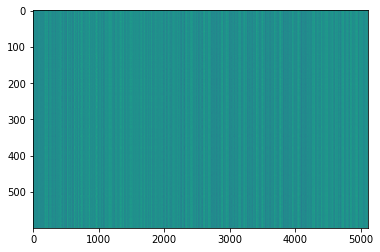

,AUC,pAUC
Source_0,0.636000,0.571579
Source_1,0.476100,0.501053
Source_2,0.634500,0.607895
Target_0,0.641700,0.618947
Target_1,0.607700,0.500000
Target_2,0.612900,0.513684
mean,0.601483,0.552193
h_mean,0.594986,0.547809


2021-06-01 14:12:32,858 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:2520.043294, val_AUC_hmean:0.594986, val_pAUC_hmean:0.547809, best_flag:True
2021-06-01 14:12:32,859 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.22it/s]
2021-06-01 14:12:33,930 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.74it/s]
2021-06-01 14:12:33,989 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.64it/s]
2021-06-01 14:12:34,053 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1611.353923, val_AUC_hmean:0.609734, val_pAUC_hmean:0.533505, best_flag:False
2021-06-01 14:12:34,056 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.65it/s]
2021-06-01 14:12:35,088 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.16it/s]
2021-06-01 14:12:35,148 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.17it/s]


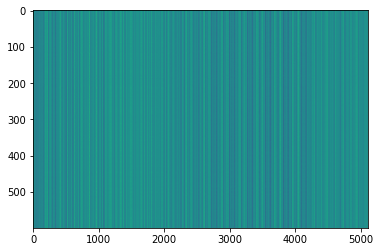

,AUC,pAUC
Source_0,0.747300,0.573684
Source_1,0.580600,0.501579
Source_2,0.754600,0.628947
Target_0,0.703300,0.601053
Target_1,0.624700,0.522632
Target_2,0.506800,0.501579
mean,0.652883,0.554912
h_mean,0.639556,0.550579


2021-06-01 14:12:37,968 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:1287.809102, val_AUC_hmean:0.639556, val_pAUC_hmean:0.550579, best_flag:True
2021-06-01 14:12:37,969 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.24it/s]
2021-06-01 14:12:39,039 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.15it/s]
2021-06-01 14:12:39,099 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.51it/s]
2021-06-01 14:12:39,165 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:1143.613190, val_AUC_hmean:0.634761, val_pAUC_hmean:0.549430, best_flag:False
2021-06-01 14:12:39,167 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.55it/s]
2021-06-01 14:12:40,207 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 55.34it/s]
2021-06-01 14:12:40,265 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.23it/s]


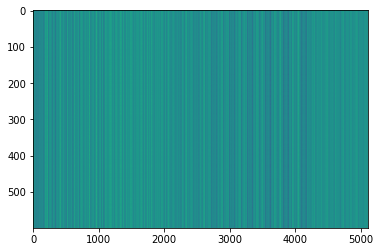

,AUC,pAUC
Source_0,0.740100,0.575789
Source_1,0.619600,0.524211
Source_2,0.756600,0.656842
Target_0,0.727800,0.653158
Target_1,0.650100,0.532632
Target_2,0.618900,0.528421
mean,0.685517,0.578509
h_mean,0.680672,0.573190


2021-06-01 14:12:43,037 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:1073.799052, val_AUC_hmean:0.680672, val_pAUC_hmean:0.573190, best_flag:True
2021-06-01 14:12:43,037 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.27it/s]
2021-06-01 14:12:44,104 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.36it/s]
2021-06-01 14:12:44,161 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.78it/s]
2021-06-01 14:12:44,226 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:1025.972117, val_AUC_hmean:0.646293, val_pAUC_hmean:0.557721, best_flag:False
2021-06-01 14:12:44,227 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.71it/s]
2021-06-01 14:12:45,254 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.58it/s]
2021-06-01 14:12:45,308 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.51it/s]
2021-06-01 14:12:

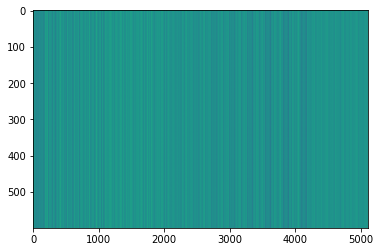

,AUC,pAUC
Source_0,0.759600,0.597368
Source_1,0.679900,0.536316
Source_2,0.775900,0.666316
Target_0,0.756300,0.656842
Target_1,0.643800,0.565789
Target_2,0.658800,0.498421
mean,0.712383,0.586842
h_mean,0.708422,0.580519


2021-06-01 14:12:50,517 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:947.641276, val_AUC_hmean:0.708422, val_pAUC_hmean:0.580519, best_flag:True
2021-06-01 14:12:50,518 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.48it/s]
2021-06-01 14:12:51,565 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 55.42it/s]
2021-06-01 14:12:51,626 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.33it/s]
2021-06-01 14:12:51,694 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:925.174327, val_AUC_hmean:0.668425, val_pAUC_hmean:0.558660, best_flag:False
2021-06-01 14:12:51,695 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.59it/s]
2021-06-01 14:12:52,733 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.55it/s]
2021-06-01 14:12:52,790 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.12it/s]


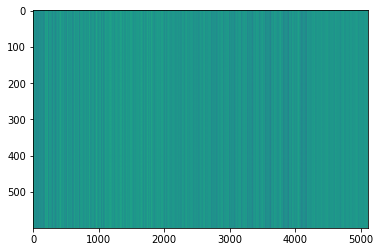

,AUC,pAUC
Source_0,0.776300,0.598947
Source_1,0.669700,0.527895
Source_2,0.822500,0.703158
Target_0,0.789600,0.681053
Target_1,0.615300,0.555789
Target_2,0.630100,0.501579
mean,0.717250,0.594737
h_mean,0.707889,0.585518


2021-06-01 14:12:55,585 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:905.195134, val_AUC_hmean:0.707889, val_pAUC_hmean:0.585518, best_flag:True
2021-06-01 14:12:55,586 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.36it/s]
2021-06-01 14:12:56,645 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.29it/s]
2021-06-01 14:12:56,701 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 49.98it/s]
2021-06-01 14:12:56,767 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:883.277105, val_AUC_hmean:0.683809, val_pAUC_hmean:0.574676, best_flag:False
2021-06-01 14:12:56,768 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.69it/s]
2021-06-01 14:12:57,796 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.27it/s]
2021-06-01 14:12:57,850 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 44.19it/s]
2021-06-01 14:12:

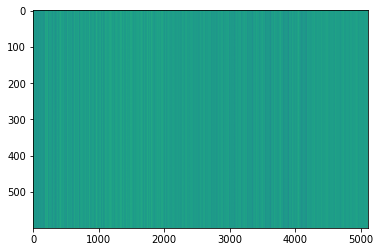

,AUC,pAUC
Source_0,0.777800,0.610526
Source_1,0.694800,0.523158
Source_2,0.836800,0.705263
Target_0,0.783300,0.664737
Target_1,0.691500,0.594737
Target_2,0.605900,0.515789
mean,0.731683,0.602368
h_mean,0.723485,0.594539


2021-06-01 14:13:11,234 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:776.001684, val_AUC_hmean:0.723485, val_pAUC_hmean:0.594539, best_flag:True
2021-06-01 14:13:11,235 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.52it/s]
2021-06-01 14:13:12,278 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 63.81it/s]
2021-06-01 14:13:12,330 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 65.49it/s]
2021-06-01 14:13:12,385 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:769.532827, val_AUC_hmean:0.699947, val_pAUC_hmean:0.581812, best_flag:False
2021-06-01 14:13:12,386 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.42it/s]
2021-06-01 14:13:13,438 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.52it/s]
2021-06-01 14:13:13,494 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 60.41it/s]
2021-06-01 14:13:

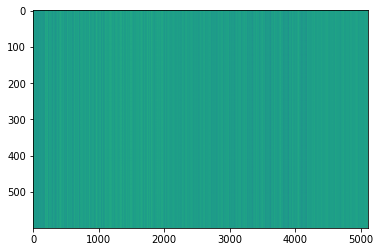

,AUC,pAUC
Source_0,0.775800,0.628947
Source_1,0.674000,0.539474
Source_2,0.837900,0.721053
Target_0,0.781200,0.668947
Target_1,0.676900,0.584737
Target_2,0.639500,0.506316
mean,0.730883,0.608246
h_mean,0.724003,0.599365


2021-06-01 14:13:17,452 - pytorch_modeler.py - INFO - epoch:25/100, train_losses:754.828868, val_AUC_hmean:0.724003, val_pAUC_hmean:0.599365, best_flag:True
2021-06-01 14:13:17,453 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.63it/s]
2021-06-01 14:13:18,487 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.20it/s]
2021-06-01 14:13:18,542 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.32it/s]
2021-06-01 14:13:18,602 - pytorch_modeler.py - INFO - epoch:26/100, train_losses:744.378337, val_AUC_hmean:0.699489, val_pAUC_hmean:0.580951, best_flag:False
2021-06-01 14:13:18,603 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.48it/s]
2021-06-01 14:13:19,651 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.56it/s]
2021-06-01 14:13:19,708 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.40it/s]
2021-06-01 14:13:

100%|██████████| 2/2 [00:00<00:00, 59.21it/s]
2021-06-01 14:13:37,252 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 58.51it/s]
2021-06-01 14:13:37,314 - pytorch_modeler.py - INFO - epoch:42/100, train_losses:652.850820, val_AUC_hmean:0.701644, val_pAUC_hmean:0.585805, best_flag:False
2021-06-01 14:13:37,315 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.58it/s]
2021-06-01 14:13:38,354 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.48it/s]
2021-06-01 14:13:38,416 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.09it/s]
2021-06-01 14:13:38,481 - pytorch_modeler.py - INFO - epoch:43/100, train_losses:648.441757, val_AUC_hmean:0.712038, val_pAUC_hmean:0.590637, best_flag:False
2021-06-01 14:13:38,482 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.54it/s]
2021-06-01 14:13:39,622 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

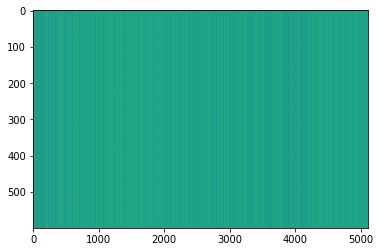

,AUC,pAUC
Source_0,0.774900,0.646316
Source_1,0.682200,0.528947
Source_2,0.821900,0.713684
Target_0,0.775500,0.692632
Target_1,0.681000,0.570526
Target_2,0.617900,0.512632
mean,0.725567,0.610789
h_mean,0.718620,0.600828


2021-06-01 14:13:47,123 - pytorch_modeler.py - INFO - epoch:48/100, train_losses:624.689219, val_AUC_hmean:0.718620, val_pAUC_hmean:0.600828, best_flag:True
2021-06-01 14:13:47,124 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.25it/s]
2021-06-01 14:13:48,193 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.57it/s]
2021-06-01 14:13:48,249 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.39it/s]
2021-06-01 14:13:48,312 - pytorch_modeler.py - INFO - epoch:49/100, train_losses:620.659032, val_AUC_hmean:0.696889, val_pAUC_hmean:0.581069, best_flag:False
2021-06-01 14:13:48,313 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.60it/s]
2021-06-01 14:13:49,349 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.98it/s]
2021-06-01 14:13:49,411 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.89it/s]
2021-06-01 14:13:

100%|██████████| 2/2 [00:00<00:00, 53.36it/s]
2021-06-01 14:14:06,951 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.40it/s]
2021-06-01 14:14:07,019 - pytorch_modeler.py - INFO - epoch:65/100, train_losses:551.875753, val_AUC_hmean:0.721366, val_pAUC_hmean:0.594476, best_flag:False
2021-06-01 14:14:07,020 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.59it/s]
2021-06-01 14:14:08,058 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 55.64it/s]
2021-06-01 14:14:08,120 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 28.66it/s]
2021-06-01 14:14:08,219 - pytorch_modeler.py - INFO - epoch:66/100, train_losses:547.503540, val_AUC_hmean:0.712692, val_pAUC_hmean:0.589889, best_flag:False
2021-06-01 14:14:08,220 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.28it/s]
2021-06-01 14:14:09,286 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:01<00:00, 11.64it/s]
2021-06-01 14:14:27,057 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 54.02it/s]
2021-06-01 14:14:27,120 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 58.35it/s]
2021-06-01 14:14:27,180 - pytorch_modeler.py - INFO - epoch:82/100, train_losses:484.537773, val_AUC_hmean:0.717004, val_pAUC_hmean:0.592556, best_flag:False
2021-06-01 14:14:27,181 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.17it/s]
2021-06-01 14:14:28,258 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.26it/s]
2021-06-01 14:14:28,330 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.07it/s]
2021-06-01 14:14:28,404 - pytorch_modeler.py - INFO - epoch:83/100, train_losses:482.893651, val_AUC_hmean:0.710923, val_pAUC_hmean:0.591401, best_flag:False
2021-06-01 14:14:28,405 - pytorch_modeler.py - INFO - train
100%|██████████|

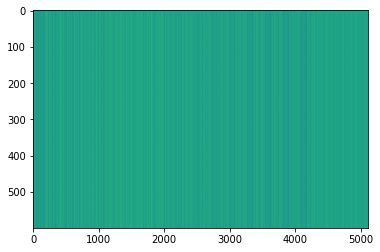

,AUC,pAUC
Source_0,0.759800,0.634211
Source_1,0.681700,0.527368
Source_2,0.847800,0.732632
Target_0,0.782400,0.685263
Target_1,0.685100,0.591053
Target_2,0.615500,0.504211
mean,0.728717,0.612456
h_mean,0.720718,0.601660


2021-06-01 14:14:37,140 - pytorch_modeler.py - INFO - epoch:88/100, train_losses:465.537318, val_AUC_hmean:0.720718, val_pAUC_hmean:0.601660, best_flag:True
2021-06-01 14:14:37,141 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.14it/s]
2021-06-01 14:14:38,220 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.35it/s]
2021-06-01 14:14:38,278 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.59it/s]
2021-06-01 14:14:38,339 - pytorch_modeler.py - INFO - epoch:89/100, train_losses:462.229139, val_AUC_hmean:0.718047, val_pAUC_hmean:0.599482, best_flag:False
2021-06-01 14:14:38,341 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.51it/s]
2021-06-01 14:14:39,386 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 54.69it/s]
2021-06-01 14:14:39,449 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.20it/s]
2021-06-01 14:14:

,AUC,pAUC
Source_0,0.759800,0.634211
Source_1,0.681700,0.527368
Source_2,0.847800,0.732632
Target_0,0.782400,0.685263
Target_1,0.685100,0.591053
Target_2,0.615500,0.504211
mean,0.728717,0.612456
h_mean,0.720718,0.601660


2021-06-01 14:14:51,238 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-06-01 14:14:51,240 - 00_train.py - INFO - MAKE DATA_LOADER
2021-06-01 14:14:51,242 - 00_train.py - INFO - TRAINING


elapsed time: 143.033473015 [sec]


2021-06-01 14:14:52,062 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.63it/s]
2021-06-01 14:14:53,095 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 54.62it/s]
2021-06-01 14:14:53,156 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.02it/s]


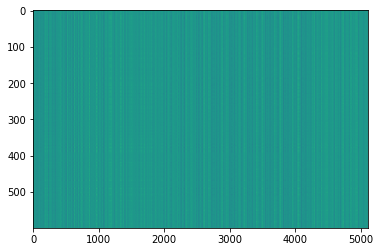

,AUC,pAUC
Source_0,0.631600,0.571579
Source_1,0.498100,0.505263
Source_2,0.641300,0.613684
Target_0,0.625900,0.610000
Target_1,0.592700,0.491053
Target_2,0.594400,0.519474
mean,0.597333,0.551842
h_mean,0.593032,0.547494


2021-06-01 14:14:55,889 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:2495.746918, val_AUC_hmean:0.593032, val_pAUC_hmean:0.547494, best_flag:True
2021-06-01 14:14:55,889 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.26it/s]
2021-06-01 14:14:56,958 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.88it/s]
2021-06-01 14:14:57,011 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.78it/s]


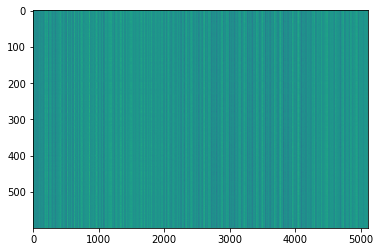

,AUC,pAUC
Source_0,0.700000,0.566842
Source_1,0.550600,0.517368
Source_2,0.655300,0.613158
Target_0,0.641800,0.603684
Target_1,0.630900,0.513158
Target_2,0.532150,0.508421
mean,0.618458,0.553772
h_mean,0.612675,0.550458


2021-06-01 14:14:59,799 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1583.625610, val_AUC_hmean:0.612675, val_pAUC_hmean:0.550458, best_flag:True
2021-06-01 14:14:59,800 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.31it/s]
2021-06-01 14:15:00,863 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 64.82it/s]
2021-06-01 14:15:00,915 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.21it/s]
2021-06-01 14:15:00,979 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:1264.911957, val_AUC_hmean:0.639291, val_pAUC_hmean:0.544270, best_flag:False
2021-06-01 14:15:00,980 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.62it/s]
2021-06-01 14:15:02,014 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.08it/s]
2021-06-01 14:15:02,071 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 64.64it/s]


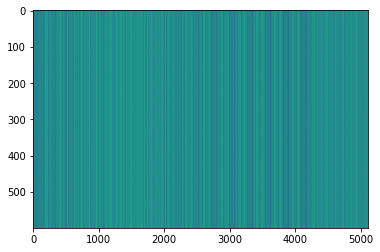

,AUC,pAUC
Source_0,0.745400,0.563158
Source_1,0.627700,0.513158
Source_2,0.775300,0.623158
Target_0,0.708000,0.580526
Target_1,0.611700,0.528421
Target_2,0.615100,0.514737
mean,0.680533,0.553860
h_mean,0.674349,0.551121


2021-06-01 14:15:04,845 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:1131.226786, val_AUC_hmean:0.674349, val_pAUC_hmean:0.551121, best_flag:True
2021-06-01 14:15:04,846 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.53it/s]
2021-06-01 14:15:05,989 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.07it/s]
2021-06-01 14:15:06,045 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 61.32it/s]


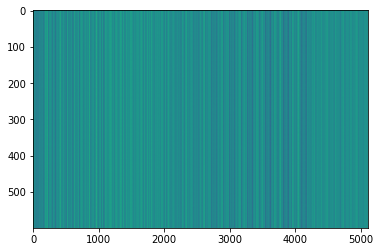

,AUC,pAUC
Source_0,0.736800,0.567368
Source_1,0.606300,0.516842
Source_2,0.776900,0.666842
Target_0,0.737100,0.617895
Target_1,0.593800,0.516316
Target_2,0.609000,0.531053
mean,0.676650,0.569386
h_mean,0.668411,0.564164


2021-06-01 14:15:08,798 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:1055.158061, val_AUC_hmean:0.668411, val_pAUC_hmean:0.564164, best_flag:True
2021-06-01 14:15:08,799 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.55it/s]
2021-06-01 14:15:09,840 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.95it/s]
2021-06-01 14:15:09,896 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.02it/s]
2021-06-01 14:15:09,967 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:1003.371902, val_AUC_hmean:0.665499, val_pAUC_hmean:0.555292, best_flag:False
2021-06-01 14:15:09,968 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.54it/s]
2021-06-01 14:15:11,009 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.16it/s]
2021-06-01 14:15:11,067 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 60.10it/s]


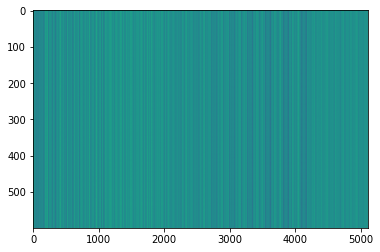

,AUC,pAUC
Source_0,0.755200,0.599474
Source_1,0.617000,0.523684
Source_2,0.807100,0.651579
Target_0,0.699300,0.631579
Target_1,0.582200,0.518947
Target_2,0.654900,0.516842
mean,0.685950,0.573684
h_mean,0.677317,0.568314


2021-06-01 14:15:13,897 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:967.995305, val_AUC_hmean:0.677317, val_pAUC_hmean:0.568314, best_flag:True
2021-06-01 14:15:13,898 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.23it/s]
2021-06-01 14:15:14,969 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.72it/s]
2021-06-01 14:15:15,030 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 58.34it/s]
2021-06-01 14:15:15,090 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:943.714971, val_AUC_hmean:0.690950, val_pAUC_hmean:0.564894, best_flag:False
2021-06-01 14:15:15,091 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.71it/s]
2021-06-01 14:15:16,118 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.08it/s]
2021-06-01 14:15:16,172 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.13it/s]


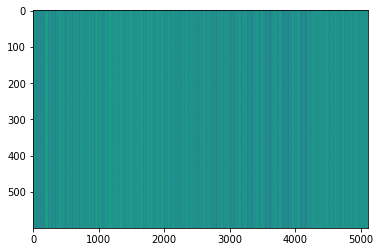

,AUC,pAUC
Source_0,0.745100,0.575789
Source_1,0.637750,0.518421
Source_2,0.822900,0.686316
Target_0,0.763000,0.631053
Target_1,0.631600,0.559474
Target_2,0.607600,0.500000
mean,0.701325,0.578509
h_mean,0.692437,0.571713


2021-06-01 14:15:19,070 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:920.732300, val_AUC_hmean:0.692437, val_pAUC_hmean:0.571713, best_flag:True
2021-06-01 14:15:19,071 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.05it/s]
2021-06-01 14:15:20,159 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.17it/s]
2021-06-01 14:15:20,215 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.04it/s]


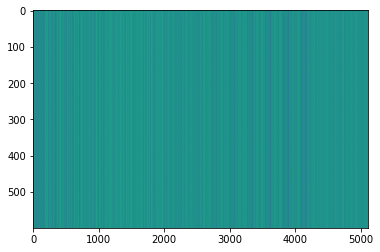

,AUC,pAUC
Source_0,0.766600,0.602105
Source_1,0.664700,0.526316
Source_2,0.795200,0.657895
Target_0,0.733500,0.630526
Target_1,0.623700,0.544737
Target_2,0.656900,0.516842
mean,0.706767,0.579737
h_mean,0.701311,0.574856


2021-06-01 14:15:23,170 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:899.990946, val_AUC_hmean:0.701311, val_pAUC_hmean:0.574856, best_flag:True
2021-06-01 14:15:23,171 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.13it/s]
2021-06-01 14:15:24,252 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.22it/s]
2021-06-01 14:15:24,316 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.13it/s]
2021-06-01 14:15:24,384 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:888.741323, val_AUC_hmean:0.646072, val_pAUC_hmean:0.556706, best_flag:False
2021-06-01 14:15:24,385 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.48it/s]
2021-06-01 14:15:25,433 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.65it/s]
2021-06-01 14:15:25,494 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.71it/s]
2021-06-01 14:15:

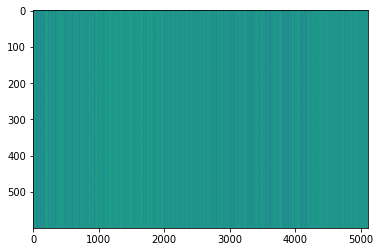

,AUC,pAUC
Source_0,0.767000,0.616316
Source_1,0.674600,0.527895
Source_2,0.848500,0.705789
Target_0,0.774800,0.670000
Target_1,0.648000,0.548947
Target_2,0.634500,0.503684
mean,0.724567,0.595439
h_mean,0.716452,0.586322


2021-06-01 14:15:29,683 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:859.288854, val_AUC_hmean:0.716452, val_pAUC_hmean:0.586322, best_flag:True
2021-06-01 14:15:29,683 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.53it/s]
2021-06-01 14:15:30,726 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 53.94it/s]
2021-06-01 14:15:30,789 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.89it/s]
2021-06-01 14:15:30,858 - pytorch_modeler.py - INFO - epoch:14/100, train_losses:840.359111, val_AUC_hmean:0.696590, val_pAUC_hmean:0.578143, best_flag:False
2021-06-01 14:15:30,859 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.61it/s]
2021-06-01 14:15:31,895 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.98it/s]
2021-06-01 14:15:31,953 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.81it/s]
2021-06-01 14:15:

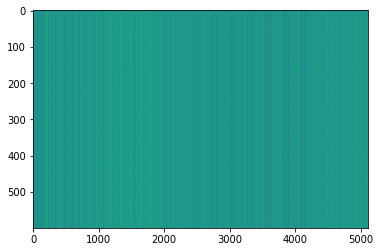

,AUC,pAUC
Source_0,0.741500,0.611579
Source_1,0.681300,0.523684
Source_2,0.839000,0.705263
Target_0,0.752000,0.656316
Target_1,0.678700,0.580526
Target_2,0.620300,0.503158
mean,0.718800,0.596754
h_mean,0.712284,0.588452


2021-06-01 14:15:36,082 - pytorch_modeler.py - INFO - epoch:16/100, train_losses:817.043360, val_AUC_hmean:0.712284, val_pAUC_hmean:0.588452, best_flag:True
2021-06-01 14:15:36,083 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.21it/s]
2021-06-01 14:15:37,156 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.50it/s]
2021-06-01 14:15:37,213 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 43.60it/s]
2021-06-01 14:15:37,292 - pytorch_modeler.py - INFO - epoch:17/100, train_losses:809.581874, val_AUC_hmean:0.705022, val_pAUC_hmean:0.582427, best_flag:False
2021-06-01 14:15:37,293 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.45it/s]
2021-06-01 14:15:38,342 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.14it/s]
2021-06-01 14:15:38,404 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.27it/s]
2021-06-01 14:15:

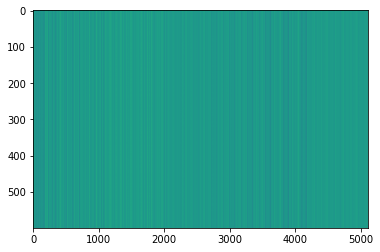

,AUC,pAUC
Source_0,0.762000,0.628947
Source_1,0.679600,0.524737
Source_2,0.853000,0.720526
Target_0,0.781400,0.677368
Target_1,0.662100,0.564211
Target_2,0.602400,0.498947
mean,0.723417,0.602456
h_mean,0.713755,0.591923


2021-06-01 14:15:43,653 - pytorch_modeler.py - INFO - epoch:20/100, train_losses:779.459295, val_AUC_hmean:0.713755, val_pAUC_hmean:0.591923, best_flag:True
2021-06-01 14:15:43,654 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.17it/s]
2021-06-01 14:15:44,731 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.84it/s]
2021-06-01 14:15:44,788 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.79it/s]


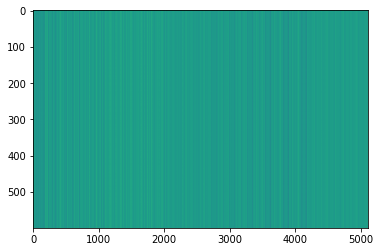

,AUC,pAUC
Source_0,0.756300,0.629474
Source_1,0.644100,0.529474
Source_2,0.782700,0.706842
Target_0,0.758200,0.673684
Target_1,0.610800,0.552105
Target_2,0.638300,0.517895
mean,0.698400,0.601579
h_mean,0.691628,0.592970


2021-06-01 14:15:47,670 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:773.937169, val_AUC_hmean:0.691628, val_pAUC_hmean:0.592970, best_flag:True
2021-06-01 14:15:47,670 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.26it/s]
2021-06-01 14:15:48,739 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.65it/s]
2021-06-01 14:15:48,797 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.88it/s]
2021-06-01 14:15:48,872 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:769.754125, val_AUC_hmean:0.701390, val_pAUC_hmean:0.578918, best_flag:False
2021-06-01 14:15:48,874 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.48it/s]
2021-06-01 14:15:49,920 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 53.66it/s]
2021-06-01 14:15:49,984 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.64it/s]


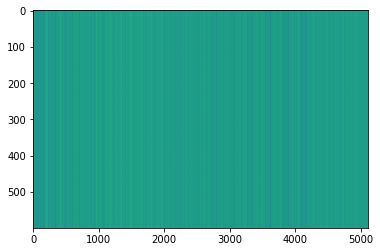

,AUC,pAUC
Source_0,0.765800,0.622632
Source_1,0.681400,0.535263
Source_2,0.834700,0.720000
Target_0,0.765000,0.660000
Target_1,0.654300,0.567895
Target_2,0.628600,0.508947
mean,0.721633,0.602456
h_mean,0.714473,0.593819


2021-06-01 14:15:53,061 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:756.039429, val_AUC_hmean:0.714473, val_pAUC_hmean:0.593819, best_flag:True
2021-06-01 14:15:53,062 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.10it/s]
2021-06-01 14:15:54,146 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.11it/s]
2021-06-01 14:15:54,201 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.90it/s]
2021-06-01 14:15:54,275 - pytorch_modeler.py - INFO - epoch:24/100, train_losses:748.775447, val_AUC_hmean:0.694003, val_pAUC_hmean:0.581373, best_flag:False
2021-06-01 14:15:54,276 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.57it/s]
2021-06-01 14:15:55,315 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.75it/s]
2021-06-01 14:15:55,376 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.64it/s]


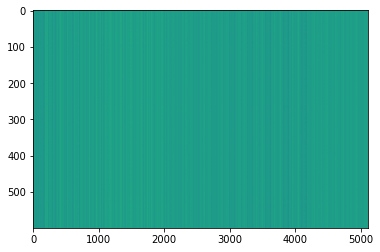

,AUC,pAUC
Source_0,0.768200,0.626842
Source_1,0.693600,0.523684
Source_2,0.852200,0.723158
Target_0,0.777500,0.674211
Target_1,0.690000,0.591053
Target_2,0.618300,0.506316
mean,0.733300,0.607544
h_mean,0.725539,0.597738


2021-06-01 14:15:58,175 - pytorch_modeler.py - INFO - epoch:25/100, train_losses:739.290248, val_AUC_hmean:0.725539, val_pAUC_hmean:0.597738, best_flag:True
2021-06-01 14:15:58,175 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.46it/s]
2021-06-01 14:15:59,224 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.85it/s]
2021-06-01 14:15:59,280 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.22it/s]
2021-06-01 14:15:59,346 - pytorch_modeler.py - INFO - epoch:26/100, train_losses:732.085515, val_AUC_hmean:0.713477, val_pAUC_hmean:0.590793, best_flag:False
2021-06-01 14:15:59,347 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.55it/s]
2021-06-01 14:16:00,387 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.63it/s]
2021-06-01 14:16:00,447 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.74it/s]
2021-06-01 14:16:

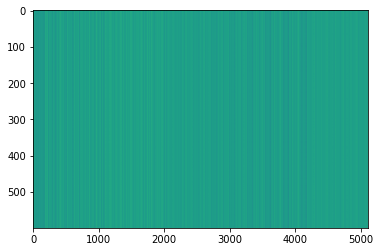

,AUC,pAUC
Source_0,0.785300,0.622105
Source_1,0.644200,0.528947
Source_2,0.854000,0.741053
Target_0,0.793400,0.682632
Target_1,0.677100,0.611579
Target_2,0.632500,0.516842
mean,0.731083,0.617193
h_mean,0.721589,0.607147


2021-06-01 14:16:04,431 - pytorch_modeler.py - INFO - epoch:28/100, train_losses:721.152568, val_AUC_hmean:0.721589, val_pAUC_hmean:0.607147, best_flag:True
2021-06-01 14:16:04,432 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.59it/s]
2021-06-01 14:16:05,470 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.89it/s]
2021-06-01 14:16:05,526 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.77it/s]
2021-06-01 14:16:05,596 - pytorch_modeler.py - INFO - epoch:29/100, train_losses:712.725306, val_AUC_hmean:0.710568, val_pAUC_hmean:0.591226, best_flag:False
2021-06-01 14:16:05,597 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.66it/s]
2021-06-01 14:16:06,628 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.26it/s]
2021-06-01 14:16:06,688 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.49it/s]
2021-06-01 14:16:

100%|██████████| 2/2 [00:00<00:00, 59.14it/s]
2021-06-01 14:16:24,063 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.47it/s]
2021-06-01 14:16:24,123 - pytorch_modeler.py - INFO - epoch:45/100, train_losses:627.462199, val_AUC_hmean:0.701893, val_pAUC_hmean:0.592880, best_flag:False
2021-06-01 14:16:24,124 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.62it/s]
2021-06-01 14:16:25,158 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.72it/s]
2021-06-01 14:16:25,215 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.96it/s]
2021-06-01 14:16:25,277 - pytorch_modeler.py - INFO - epoch:46/100, train_losses:622.885783, val_AUC_hmean:0.707465, val_pAUC_hmean:0.595858, best_flag:False
2021-06-01 14:16:25,279 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.25it/s]
2021-06-01 14:16:26,347 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:01<00:00, 11.70it/s]
2021-06-01 14:16:43,918 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.97it/s]
2021-06-01 14:16:43,975 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.67it/s]
2021-06-01 14:16:44,043 - pytorch_modeler.py - INFO - epoch:62/100, train_losses:551.079539, val_AUC_hmean:0.696257, val_pAUC_hmean:0.588913, best_flag:False
2021-06-01 14:16:44,044 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.71it/s]
2021-06-01 14:16:45,071 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.24it/s]
2021-06-01 14:16:45,128 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.17it/s]
2021-06-01 14:16:45,197 - pytorch_modeler.py - INFO - epoch:63/100, train_losses:549.457031, val_AUC_hmean:0.695451, val_pAUC_hmean:0.584981, best_flag:False
2021-06-01 14:16:45,198 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-06-01 14:17:03,127 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.52it/s]
2021-06-01 14:17:04,171 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.46it/s]
2021-06-01 14:17:04,229 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.20it/s]
2021-06-01 14:17:04,295 - pytorch_modeler.py - INFO - epoch:79/100, train_losses:492.628904, val_AUC_hmean:0.713409, val_pAUC_hmean:0.597565, best_flag:False
2021-06-01 14:17:04,297 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.65it/s]
2021-06-01 14:17:05,329 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.27it/s]
2021-06-01 14:17:05,387 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 61.44it/s]
2021-06-01 14:17:05,447 - pytorch_modeler.py - INFO - epoch:80/100, train_losses:487.869642, val_AUC_hmean:0.712936, val_pAUC_hmean:0.602548, best_flag:False
2021-06-01 14:17

100%|██████████| 2/2 [00:00<00:00, 54.41it/s]
2021-06-01 14:17:23,270 - pytorch_modeler.py - INFO - epoch:95/100, train_losses:432.138123, val_AUC_hmean:0.702623, val_pAUC_hmean:0.586788, best_flag:False
2021-06-01 14:17:23,271 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.21it/s]
2021-06-01 14:17:24,344 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.58it/s]
2021-06-01 14:17:24,411 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.55it/s]
2021-06-01 14:17:24,475 - pytorch_modeler.py - INFO - epoch:96/100, train_losses:429.970846, val_AUC_hmean:0.700317, val_pAUC_hmean:0.588326, best_flag:False
2021-06-01 14:17:24,476 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.34it/s]
2021-06-01 14:17:25,536 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.07it/s]
2021-06-01 14:17:25,600 - pytorch_modeler.py - INFO - valid_target
100%|██████████|

,AUC,pAUC
Source_0,0.785300,0.622105
Source_1,0.644200,0.528947
Source_2,0.854000,0.741053
Target_0,0.793400,0.682632
Target_1,0.677100,0.611579
Target_2,0.632500,0.516842
mean,0.731083,0.617193
h_mean,0.721589,0.607147


2021-06-01 14:17:29,361 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-06-01 14:17:29,362 - 00_train.py - INFO - MAKE DATA_LOADER
2021-06-01 14:17:29,364 - 00_train.py - INFO - TRAINING


elapsed time: 158.122426987 [sec]


2021-06-01 14:17:30,172 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.52it/s]
2021-06-01 14:17:31,216 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.34it/s]
2021-06-01 14:17:31,271 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.63it/s]


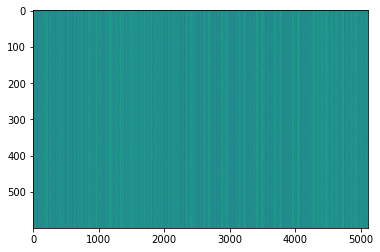

,AUC,pAUC
Source_0,0.634500,0.571579
Source_1,0.490300,0.491579
Source_2,0.628200,0.610000
Target_0,0.635600,0.617368
Target_1,0.617900,0.508421
Target_2,0.603800,0.519474
mean,0.601717,0.553070
h_mean,0.596698,0.548706


2021-06-01 14:17:34,106 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:2472.442240, val_AUC_hmean:0.596698, val_pAUC_hmean:0.548706, best_flag:True
2021-06-01 14:17:34,107 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00,  9.98it/s]
2021-06-01 14:17:35,313 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 46.99it/s]
2021-06-01 14:17:35,382 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.19it/s]
2021-06-01 14:17:35,447 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1574.771230, val_AUC_hmean:0.615983, val_pAUC_hmean:0.534201, best_flag:False
2021-06-01 14:17:35,449 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.12it/s]
2021-06-01 14:17:36,531 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.13it/s]
2021-06-01 14:17:36,589 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.48it/s]


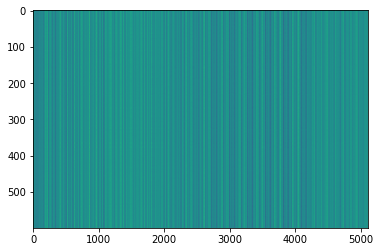

,AUC,pAUC
Source_0,0.729600,0.572632
Source_1,0.612900,0.518947
Source_2,0.732600,0.586316
Target_0,0.710200,0.604211
Target_1,0.649200,0.538421
Target_2,0.557400,0.510000
mean,0.665317,0.555088
h_mean,0.658642,0.552894


2021-06-01 14:17:39,952 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:1262.365967, val_AUC_hmean:0.658642, val_pAUC_hmean:0.552894, best_flag:True
2021-06-01 14:17:39,953 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.69it/s]
2021-06-01 14:17:41,079 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.80it/s]
2021-06-01 14:17:41,145 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.43it/s]


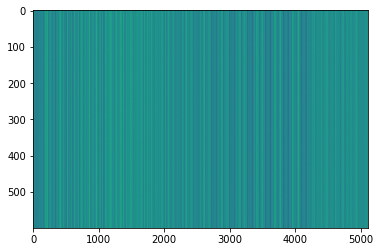

,AUC,pAUC
Source_0,0.70630,0.556316
Source_1,0.60770,0.515263
Source_2,0.76700,0.646842
Target_0,0.70010,0.581579
Target_1,0.59320,0.530526
Target_2,0.58870,0.517368
mean,0.66050,0.557982
h_mean,0.65374,0.554452


2021-06-01 14:17:44,521 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:1130.270691, val_AUC_hmean:0.653740, val_pAUC_hmean:0.554452, best_flag:True
2021-06-01 14:17:44,522 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.30it/s]
2021-06-01 14:17:45,588 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 54.21it/s]
2021-06-01 14:17:45,651 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.06it/s]


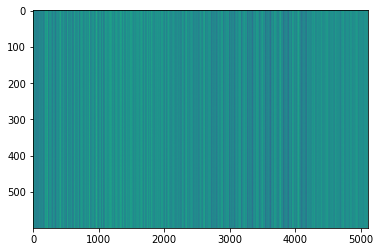

,AUC,pAUC
Source_0,0.720800,0.575263
Source_1,0.587300,0.520526
Source_2,0.770700,0.634211
Target_0,0.723200,0.628421
Target_1,0.608600,0.554737
Target_2,0.614300,0.532105
mean,0.670817,0.574211
h_mean,0.663621,0.570912


2021-06-01 14:17:48,629 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:1053.233495, val_AUC_hmean:0.663621, val_pAUC_hmean:0.570912, best_flag:True
2021-06-01 14:17:48,630 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.58it/s]
2021-06-01 14:17:49,669 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 52.49it/s]
2021-06-01 14:17:49,733 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.63it/s]
2021-06-01 14:17:49,799 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:1001.939987, val_AUC_hmean:0.663270, val_pAUC_hmean:0.552234, best_flag:False
2021-06-01 14:17:49,801 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.49it/s]
2021-06-01 14:17:50,847 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.13it/s]
2021-06-01 14:17:50,906 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.89it/s]


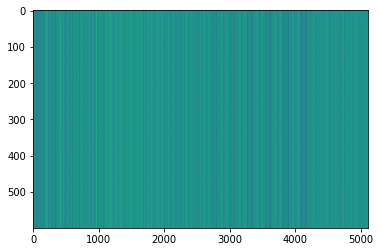

,AUC,pAUC
Source_0,0.749900,0.586316
Source_1,0.603800,0.521053
Source_2,0.830000,0.689474
Target_0,0.761500,0.632632
Target_1,0.620600,0.566316
Target_2,0.586700,0.512105
mean,0.692083,0.584649
h_mean,0.680002,0.578349


2021-06-01 14:17:53,724 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:960.608897, val_AUC_hmean:0.680002, val_pAUC_hmean:0.578349, best_flag:True
2021-06-01 14:17:53,725 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.39it/s]
2021-06-01 14:17:54,783 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.33it/s]
2021-06-01 14:17:54,843 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.20it/s]
2021-06-01 14:17:54,915 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:940.004908, val_AUC_hmean:0.697303, val_pAUC_hmean:0.577259, best_flag:False
2021-06-01 14:17:54,917 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.47it/s]
2021-06-01 14:17:55,965 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.20it/s]
2021-06-01 14:17:56,027 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.83it/s]
2021-06-01 14:17:56

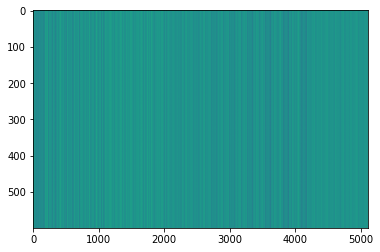

,AUC,pAUC
Source_0,0.739600,0.602632
Source_1,0.667300,0.527368
Source_2,0.826300,0.720526
Target_0,0.753800,0.638421
Target_1,0.615400,0.557368
Target_2,0.637000,0.516842
mean,0.706567,0.593860
h_mean,0.699113,0.586006


2021-06-01 14:18:01,250 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:880.269455, val_AUC_hmean:0.699113, val_pAUC_hmean:0.586006, best_flag:True
2021-06-01 14:18:01,250 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.17it/s]
2021-06-01 14:18:02,328 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.85it/s]
2021-06-01 14:18:02,385 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.61it/s]
2021-06-01 14:18:02,457 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:862.753001, val_AUC_hmean:0.687560, val_pAUC_hmean:0.573395, best_flag:False
2021-06-01 14:18:02,459 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.60it/s]
2021-06-01 14:18:03,495 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.36it/s]
2021-06-01 14:18:03,556 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.08it/s]
2021-06-01 14:18:

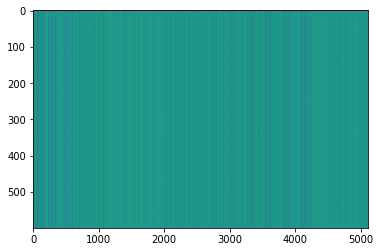

,AUC,pAUC
Source_0,0.782300,0.612105
Source_1,0.704900,0.528947
Source_2,0.798600,0.666842
Target_0,0.792200,0.670000
Target_1,0.668900,0.582105
Target_2,0.637600,0.533158
mean,0.730750,0.598860
h_mean,0.725093,0.593477


2021-06-01 14:18:09,890 - pytorch_modeler.py - INFO - epoch:16/100, train_losses:809.972366, val_AUC_hmean:0.725093, val_pAUC_hmean:0.593477, best_flag:True
2021-06-01 14:18:09,891 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.15it/s]
2021-06-01 14:18:10,970 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.71it/s]
2021-06-01 14:18:11,029 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.61it/s]
2021-06-01 14:18:11,096 - pytorch_modeler.py - INFO - epoch:17/100, train_losses:798.170354, val_AUC_hmean:0.716380, val_pAUC_hmean:0.585851, best_flag:False
2021-06-01 14:18:11,097 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.45it/s]
2021-06-01 14:18:12,148 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 55.29it/s]
2021-06-01 14:18:12,214 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.71it/s]
2021-06-01 14:18:

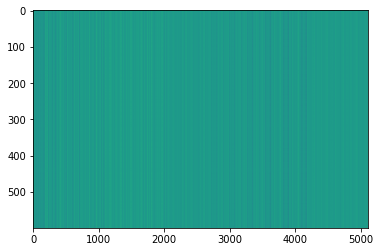

,AUC,pAUC
Source_0,0.759600,0.628947
Source_1,0.632400,0.522105
Source_2,0.853300,0.716842
Target_0,0.776900,0.667895
Target_1,0.675100,0.611579
Target_2,0.623000,0.516316
mean,0.720050,0.610614
h_mean,0.710627,0.601839


2021-06-01 14:18:17,530 - pytorch_modeler.py - INFO - epoch:20/100, train_losses:770.592112, val_AUC_hmean:0.710627, val_pAUC_hmean:0.601839, best_flag:True
2021-06-01 14:18:17,531 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.18it/s]
2021-06-01 14:18:18,607 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.34it/s]
2021-06-01 14:18:18,662 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.50it/s]
2021-06-01 14:18:18,729 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:767.440765, val_AUC_hmean:0.683952, val_pAUC_hmean:0.576683, best_flag:False
2021-06-01 14:18:18,730 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.68it/s]
2021-06-01 14:18:19,759 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.42it/s]
2021-06-01 14:18:19,815 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.02it/s]
2021-06-01 14:18:

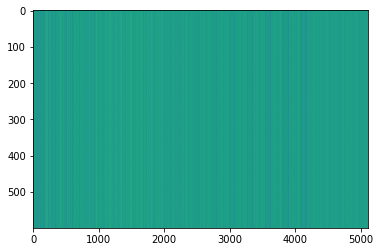

,AUC,pAUC
Source_0,0.749400,0.622632
Source_1,0.686200,0.520526
Source_2,0.837500,0.717368
Target_0,0.778000,0.681053
Target_1,0.688800,0.615263
Target_2,0.616000,0.515263
mean,0.725983,0.612018
h_mean,0.718885,0.602676


2021-06-01 14:18:27,344 - pytorch_modeler.py - INFO - epoch:26/100, train_losses:723.320480, val_AUC_hmean:0.718885, val_pAUC_hmean:0.602676, best_flag:True
2021-06-01 14:18:27,345 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.18it/s]
2021-06-01 14:18:28,420 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.38it/s]
2021-06-01 14:18:28,482 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.93it/s]
2021-06-01 14:18:28,556 - pytorch_modeler.py - INFO - epoch:27/100, train_losses:716.170308, val_AUC_hmean:0.707933, val_pAUC_hmean:0.584867, best_flag:False
2021-06-01 14:18:28,557 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.59it/s]
2021-06-01 14:18:29,595 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.59it/s]
2021-06-01 14:18:29,649 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 58.77it/s]
2021-06-01 14:18:

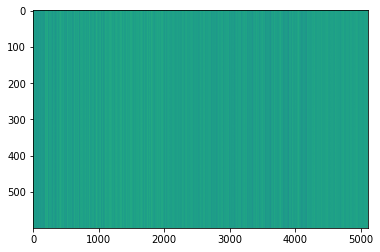

,AUC,pAUC
Source_0,0.775000,0.635789
Source_1,0.717600,0.530526
Source_2,0.834800,0.714737
Target_0,0.785700,0.687895
Target_1,0.679900,0.580000
Target_2,0.623600,0.525263
mean,0.736100,0.612368
h_mean,0.729138,0.603710


2021-06-01 14:18:34,815 - pytorch_modeler.py - INFO - epoch:30/100, train_losses:695.966919, val_AUC_hmean:0.729138, val_pAUC_hmean:0.603710, best_flag:True
2021-06-01 14:18:34,816 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.96it/s]
2021-06-01 14:18:35,913 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 29.84it/s]
2021-06-01 14:18:36,002 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.58it/s]
2021-06-01 14:18:36,063 - pytorch_modeler.py - INFO - epoch:31/100, train_losses:689.271159, val_AUC_hmean:0.723295, val_pAUC_hmean:0.602228, best_flag:False
2021-06-01 14:18:36,064 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.12it/s]
2021-06-01 14:18:37,145 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.67it/s]
2021-06-01 14:18:37,201 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.40it/s]
2021-06-01 14:18:

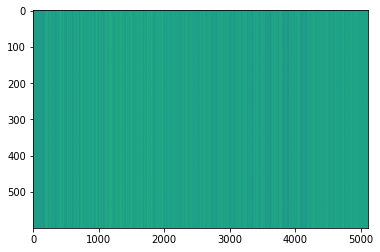

,AUC,pAUC
Source_0,0.773500,0.641053
Source_1,0.694000,0.537895
Source_2,0.849800,0.716842
Target_0,0.794100,0.674211
Target_1,0.703300,0.597895
Target_2,0.595800,0.512105
mean,0.735083,0.613333
h_mean,0.725508,0.604685


2021-06-01 14:18:55,221 - pytorch_modeler.py - INFO - epoch:45/100, train_losses:627.733729, val_AUC_hmean:0.725508, val_pAUC_hmean:0.604685, best_flag:True
2021-06-01 14:18:55,222 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.26it/s]
2021-06-01 14:18:56,290 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.92it/s]
2021-06-01 14:18:56,345 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.03it/s]
2021-06-01 14:18:56,406 - pytorch_modeler.py - INFO - epoch:46/100, train_losses:617.777186, val_AUC_hmean:0.706615, val_pAUC_hmean:0.590645, best_flag:False
2021-06-01 14:18:56,407 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.65it/s]
2021-06-01 14:18:57,439 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.19it/s]
2021-06-01 14:18:57,492 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 43.91it/s]
2021-06-01 14:18:

100%|██████████| 2/2 [00:00<00:00, 61.77it/s]
2021-06-01 14:19:15,145 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 63.06it/s]
2021-06-01 14:19:15,204 - pytorch_modeler.py - INFO - epoch:62/100, train_losses:544.982610, val_AUC_hmean:0.704667, val_pAUC_hmean:0.587452, best_flag:False
2021-06-01 14:19:15,205 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.65it/s]
2021-06-01 14:19:16,237 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.74it/s]
2021-06-01 14:19:16,294 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.69it/s]
2021-06-01 14:19:16,365 - pytorch_modeler.py - INFO - epoch:63/100, train_losses:539.996648, val_AUC_hmean:0.720135, val_pAUC_hmean:0.601968, best_flag:False
2021-06-01 14:19:16,366 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.61it/s]
2021-06-01 14:19:17,401 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

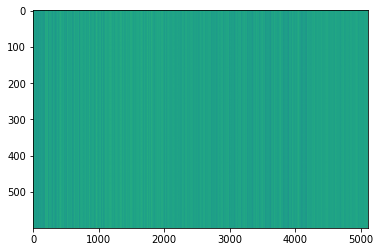

,AUC,pAUC
Source_0,0.767100,0.642632
Source_1,0.701500,0.538947
Source_2,0.831700,0.722632
Target_0,0.754600,0.677368
Target_1,0.686700,0.585789
Target_2,0.617000,0.518421
mean,0.726433,0.614298
h_mean,0.719970,0.605587


2021-06-01 14:19:23,711 - pytorch_modeler.py - INFO - epoch:67/100, train_losses:525.047429, val_AUC_hmean:0.719970, val_pAUC_hmean:0.605587, best_flag:True
2021-06-01 14:19:23,712 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.38it/s]
2021-06-01 14:19:24,769 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.07it/s]
2021-06-01 14:19:24,825 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.71it/s]
2021-06-01 14:19:24,889 - pytorch_modeler.py - INFO - epoch:68/100, train_losses:519.923615, val_AUC_hmean:0.707844, val_pAUC_hmean:0.588867, best_flag:False
2021-06-01 14:19:24,891 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.75it/s]
2021-06-01 14:19:25,914 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.08it/s]
2021-06-01 14:19:25,970 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 36.35it/s]
2021-06-01 14:19:

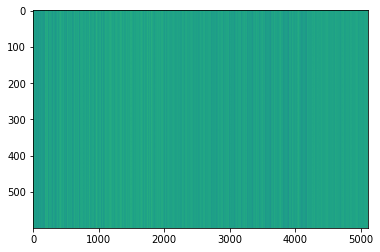

,AUC,pAUC
Source_0,0.740700,0.643684
Source_1,0.715900,0.537368
Source_2,0.844300,0.721053
Target_0,0.758000,0.677895
Target_1,0.684700,0.596842
Target_2,0.613300,0.515263
mean,0.726150,0.615351
h_mean,0.719286,0.606506


2021-06-01 14:19:30,077 - pytorch_modeler.py - INFO - epoch:70/100, train_losses:513.740550, val_AUC_hmean:0.719286, val_pAUC_hmean:0.606506, best_flag:True
2021-06-01 14:19:30,077 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.52it/s]
2021-06-01 14:19:31,122 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.91it/s]
2021-06-01 14:19:31,181 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 58.26it/s]
2021-06-01 14:19:31,242 - pytorch_modeler.py - INFO - epoch:71/100, train_losses:509.127721, val_AUC_hmean:0.708825, val_pAUC_hmean:0.592770, best_flag:False
2021-06-01 14:19:31,244 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.65it/s]
2021-06-01 14:19:32,277 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 55.22it/s]
2021-06-01 14:19:32,341 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 61.49it/s]
2021-06-01 14:19:

100%|██████████| 2/2 [00:00<00:00, 57.49it/s]
2021-06-01 14:19:50,267 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.65it/s]
2021-06-01 14:19:50,331 - pytorch_modeler.py - INFO - epoch:87/100, train_losses:450.331863, val_AUC_hmean:0.706904, val_pAUC_hmean:0.589842, best_flag:False
2021-06-01 14:19:50,332 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.54it/s]
2021-06-01 14:19:51,374 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 54.41it/s]
2021-06-01 14:19:51,435 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.53it/s]
2021-06-01 14:19:51,497 - pytorch_modeler.py - INFO - epoch:88/100, train_losses:448.677142, val_AUC_hmean:0.713082, val_pAUC_hmean:0.601763, best_flag:False
2021-06-01 14:19:51,498 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.54it/s]
2021-06-01 14:19:52,540 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

,AUC,pAUC
Source_0,0.740700,0.643684
Source_1,0.715900,0.537368
Source_2,0.844300,0.721053
Target_0,0.758000,0.677895
Target_1,0.684700,0.596842
Target_2,0.613300,0.515263
mean,0.726150,0.615351
h_mean,0.719286,0.606506


2021-06-01 14:20:05,471 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-06-01 14:20:05,472 - 00_train.py - INFO - MAKE DATA_LOADER
2021-06-01 14:20:05,474 - 00_train.py - INFO - TRAINING


elapsed time: 156.108184099 [sec]


2021-06-01 14:20:06,311 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.52it/s]
2021-06-01 14:20:07,355 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.15it/s]
2021-06-01 14:20:07,411 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 58.36it/s]


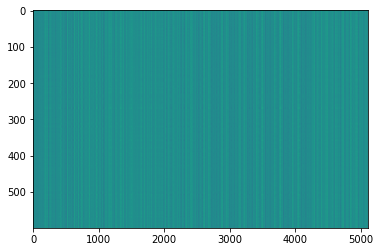

,AUC,pAUC
Source_0,0.644600,0.560526
Source_1,0.501400,0.504211
Source_2,0.639300,0.627368
Target_0,0.631200,0.620526
Target_1,0.555800,0.475789
Target_2,0.605800,0.524211
mean,0.596350,0.552105
h_mean,0.591472,0.546337


2021-06-01 14:20:10,330 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:2531.717916, val_AUC_hmean:0.591472, val_pAUC_hmean:0.546337, best_flag:True
2021-06-01 14:20:10,331 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.37it/s]
2021-06-01 14:20:11,389 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.51it/s]
2021-06-01 14:20:11,442 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 49.74it/s]
2021-06-01 14:20:11,511 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1610.584076, val_AUC_hmean:0.609514, val_pAUC_hmean:0.543805, best_flag:False
2021-06-01 14:20:11,512 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.67it/s]
2021-06-01 14:20:12,541 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.33it/s]
2021-06-01 14:20:12,600 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.60it/s]


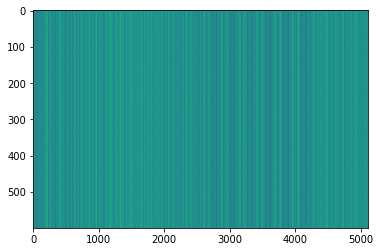

,AUC,pAUC
Source_0,0.735000,0.583684
Source_1,0.586400,0.512105
Source_2,0.690800,0.655789
Target_0,0.700900,0.600526
Target_1,0.654000,0.545789
Target_2,0.491900,0.508421
mean,0.643167,0.567719
h_mean,0.631434,0.563108


2021-06-01 14:20:15,670 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:1293.719533, val_AUC_hmean:0.631434, val_pAUC_hmean:0.563108, best_flag:True
2021-06-01 14:20:15,671 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.13it/s]
2021-06-01 14:20:16,752 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.40it/s]
2021-06-01 14:20:16,806 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.34it/s]
2021-06-01 14:20:16,875 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:1164.777496, val_AUC_hmean:0.634050, val_pAUC_hmean:0.557638, best_flag:False
2021-06-01 14:20:16,876 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.55it/s]
2021-06-01 14:20:17,917 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.67it/s]
2021-06-01 14:20:17,977 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.22it/s]
2021-06-01 14:20:

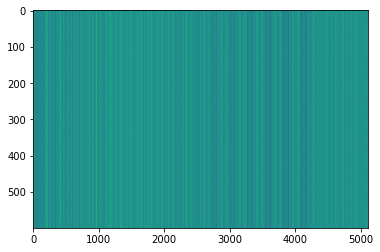

,AUC,pAUC
Source_0,0.740900,0.592632
Source_1,0.648500,0.522632
Source_2,0.771400,0.672632
Target_0,0.745400,0.670526
Target_1,0.624800,0.518947
Target_2,0.659300,0.513684
mean,0.698383,0.581842
h_mean,0.693890,0.574023


2021-06-01 14:20:22,118 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:1039.720001, val_AUC_hmean:0.693890, val_pAUC_hmean:0.574023, best_flag:True
2021-06-01 14:20:22,118 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.45it/s]
2021-06-01 14:20:23,168 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 55.27it/s]
2021-06-01 14:20:23,232 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.34it/s]
2021-06-01 14:20:23,297 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:1002.544983, val_AUC_hmean:0.673866, val_pAUC_hmean:0.558553, best_flag:False
2021-06-01 14:20:23,298 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.62it/s]
2021-06-01 14:20:24,333 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.57it/s]
2021-06-01 14:20:24,388 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.27it/s]
2021-06-01 14:20:

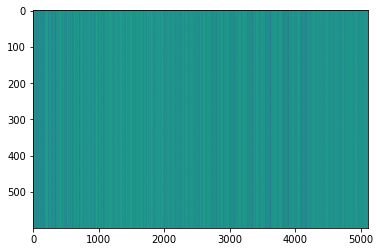

,AUC,pAUC
Source_0,0.714000,0.584211
Source_1,0.661600,0.533158
Source_2,0.813500,0.678421
Target_0,0.762900,0.681053
Target_1,0.613800,0.544211
Target_2,0.640700,0.517368
mean,0.701083,0.589737
h_mean,0.694277,0.582522


2021-06-01 14:20:29,794 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:928.397425, val_AUC_hmean:0.694277, val_pAUC_hmean:0.582522, best_flag:True
2021-06-01 14:20:29,795 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.49it/s]
2021-06-01 14:20:30,841 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.85it/s]
2021-06-01 14:20:30,901 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 49.87it/s]
2021-06-01 14:20:30,970 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:908.952627, val_AUC_hmean:0.686310, val_pAUC_hmean:0.561394, best_flag:False
2021-06-01 14:20:30,971 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.56it/s]
2021-06-01 14:20:32,012 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.14it/s]
2021-06-01 14:20:32,065 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.04it/s]


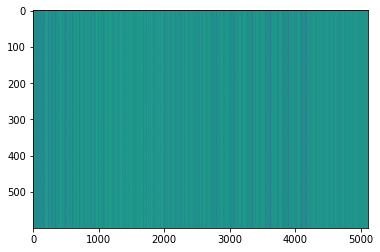

,AUC,pAUC
Source_0,0.760200,0.608947
Source_1,0.640100,0.518421
Source_2,0.856500,0.721053
Target_0,0.785400,0.690000
Target_1,0.643800,0.571579
Target_2,0.612500,0.495263
mean,0.716417,0.600877
h_mean,0.705516,0.589627


2021-06-01 14:20:35,077 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:894.220357, val_AUC_hmean:0.705516, val_pAUC_hmean:0.589627, best_flag:True
2021-06-01 14:20:35,078 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.60it/s]
2021-06-01 14:20:36,114 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.10it/s]
2021-06-01 14:20:36,174 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 30.15it/s]
2021-06-01 14:20:36,267 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:879.003749, val_AUC_hmean:0.707210, val_pAUC_hmean:0.572943, best_flag:False
2021-06-01 14:20:36,268 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.59it/s]
2021-06-01 14:20:37,305 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.44it/s]
2021-06-01 14:20:37,359 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 44.06it/s]
2021-06-01 14:20:

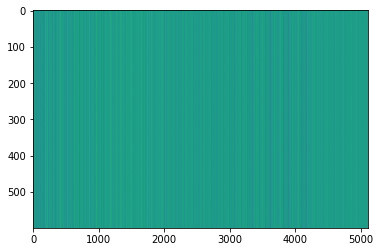

,AUC,pAUC
Source_0,0.735300,0.618947
Source_1,0.669000,0.514211
Source_2,0.862100,0.752632
Target_0,0.776000,0.676842
Target_1,0.671500,0.590000
Target_2,0.601300,0.501579
mean,0.719200,0.609035
h_mean,0.709585,0.596711


2021-06-01 14:20:48,522 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:790.143204, val_AUC_hmean:0.709585, val_pAUC_hmean:0.596711, best_flag:True
2021-06-01 14:20:48,523 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.11it/s]
2021-06-01 14:20:49,605 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.50it/s]
2021-06-01 14:20:49,673 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.33it/s]


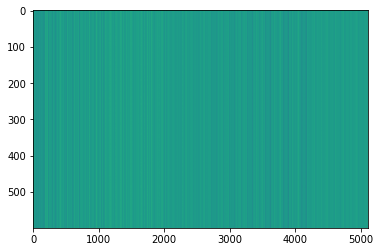

,AUC,pAUC
Source_0,0.755500,0.616842
Source_1,0.684800,0.528421
Source_2,0.830600,0.731579
Target_0,0.770300,0.652105
Target_1,0.670800,0.589474
Target_2,0.628500,0.522632
mean,0.723417,0.606842
h_mean,0.717026,0.598575


2021-06-01 14:20:52,741 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:786.715134, val_AUC_hmean:0.717026, val_pAUC_hmean:0.598575, best_flag:True
2021-06-01 14:20:52,742 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.21it/s]
2021-06-01 14:20:53,814 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.76it/s]
2021-06-01 14:20:53,868 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.88it/s]
2021-06-01 14:20:53,935 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:774.814458, val_AUC_hmean:0.708108, val_pAUC_hmean:0.589475, best_flag:False
2021-06-01 14:20:53,936 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.64it/s]
2021-06-01 14:20:54,969 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.58it/s]
2021-06-01 14:20:55,024 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.03it/s]
2021-06-01 14:20:

100%|██████████| 2/2 [00:00<00:00, 60.38it/s]
2021-06-01 14:21:12,690 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.25it/s]
2021-06-01 14:21:12,755 - pytorch_modeler.py - INFO - epoch:39/100, train_losses:677.644770, val_AUC_hmean:0.693865, val_pAUC_hmean:0.578104, best_flag:False
2021-06-01 14:21:12,757 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.60it/s]
2021-06-01 14:21:13,794 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.36it/s]
2021-06-01 14:21:13,850 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.93it/s]
2021-06-01 14:21:13,915 - pytorch_modeler.py - INFO - epoch:40/100, train_losses:671.548548, val_AUC_hmean:0.691901, val_pAUC_hmean:0.591610, best_flag:False
2021-06-01 14:21:13,916 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.52it/s]
2021-06-01 14:21:14,961 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

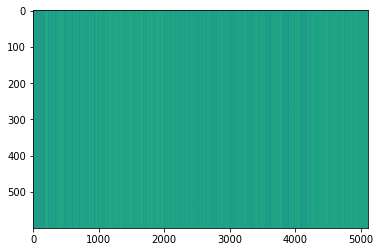

,AUC,pAUC
Source_0,0.743900,0.642105
Source_1,0.664300,0.520526
Source_2,0.853900,0.733158
Target_0,0.758700,0.677368
Target_1,0.682000,0.634737
Target_2,0.594800,0.500000
mean,0.716267,0.617982
h_mean,0.707025,0.606414


2021-06-01 14:21:24,893 - pytorch_modeler.py - INFO - epoch:47/100, train_losses:634.932744, val_AUC_hmean:0.707025, val_pAUC_hmean:0.606414, best_flag:True
2021-06-01 14:21:24,894 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.18it/s]
2021-06-01 14:21:25,969 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.23it/s]
2021-06-01 14:21:26,025 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.26it/s]
2021-06-01 14:21:26,093 - pytorch_modeler.py - INFO - epoch:48/100, train_losses:629.981476, val_AUC_hmean:0.701095, val_pAUC_hmean:0.590414, best_flag:False
2021-06-01 14:21:26,094 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.63it/s]
2021-06-01 14:21:27,128 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.39it/s]
2021-06-01 14:21:27,183 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.96it/s]
2021-06-01 14:21:

100%|██████████| 2/2 [00:00<00:00, 58.12it/s]
2021-06-01 14:21:45,118 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.18it/s]
2021-06-01 14:21:45,184 - pytorch_modeler.py - INFO - epoch:64/100, train_losses:561.916519, val_AUC_hmean:0.701880, val_pAUC_hmean:0.585462, best_flag:False
2021-06-01 14:21:45,186 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.64it/s]
2021-06-01 14:21:46,219 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.35it/s]
2021-06-01 14:21:46,278 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.30it/s]
2021-06-01 14:21:46,339 - pytorch_modeler.py - INFO - epoch:65/100, train_losses:559.940791, val_AUC_hmean:0.706420, val_pAUC_hmean:0.594111, best_flag:False
2021-06-01 14:21:46,340 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.61it/s]
2021-06-01 14:21:47,376 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:01<00:00, 11.58it/s]
2021-06-01 14:22:04,833 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 50.95it/s]
2021-06-01 14:22:04,897 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 60.80it/s]
2021-06-01 14:22:04,956 - pytorch_modeler.py - INFO - epoch:81/100, train_losses:498.661423, val_AUC_hmean:0.707311, val_pAUC_hmean:0.590103, best_flag:False
2021-06-01 14:22:04,957 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.60it/s]
2021-06-01 14:22:05,994 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.98it/s]
2021-06-01 14:22:06,057 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.41it/s]
2021-06-01 14:22:06,118 - pytorch_modeler.py - INFO - epoch:82/100, train_losses:492.940018, val_AUC_hmean:0.702258, val_pAUC_hmean:0.586142, best_flag:False
2021-06-01 14:22:06,119 - pytorch_modeler.py - INFO - train
100%|██████████|

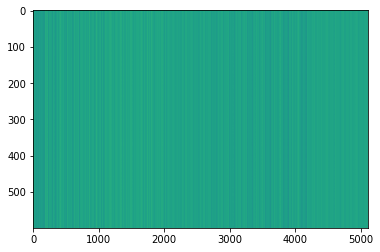

,AUC,pAUC
Source_0,0.748000,0.643158
Source_1,0.699200,0.523158
Source_2,0.836200,0.728421
Target_0,0.772600,0.687368
Target_1,0.679900,0.610526
Target_2,0.614100,0.512632
mean,0.725000,0.617544
h_mean,0.718002,0.607127


2021-06-01 14:22:26,575 - pytorch_modeler.py - INFO - epoch:97/100, train_losses:442.559479, val_AUC_hmean:0.718002, val_pAUC_hmean:0.607127, best_flag:True
2021-06-01 14:22:26,576 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.19it/s]
2021-06-01 14:22:27,651 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.89it/s]
2021-06-01 14:22:27,703 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.05it/s]
2021-06-01 14:22:27,768 - pytorch_modeler.py - INFO - epoch:98/100, train_losses:437.269958, val_AUC_hmean:0.700490, val_pAUC_hmean:0.584761, best_flag:False
2021-06-01 14:22:27,769 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.67it/s]
2021-06-01 14:22:28,799 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.19it/s]
2021-06-01 14:22:28,856 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.82it/s]
2021-06-01 14:22:

,AUC,pAUC
Source_0,0.748000,0.643158
Source_1,0.699200,0.523158
Source_2,0.836200,0.728421
Target_0,0.772600,0.687368
Target_1,0.679900,0.610526
Target_2,0.614100,0.512632
mean,0.725000,0.617544
h_mean,0.718002,0.607127


2021-06-01 14:22:30,090 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-06-01 14:22:30,091 - 00_train.py - INFO - MAKE DATA_LOADER
2021-06-01 14:22:30,092 - 00_train.py - INFO - TRAINING


elapsed time: 144.618770599 [sec]


2021-06-01 14:22:30,915 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.57it/s]
2021-06-01 14:22:31,954 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.62it/s]
2021-06-01 14:22:32,014 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.56it/s]


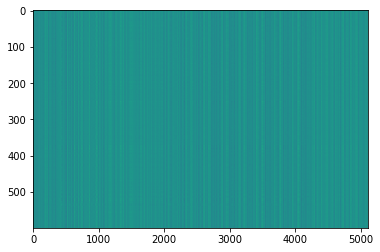

,AUC,pAUC
Source_0,0.639300,0.560526
Source_1,0.490200,0.498947
Source_2,0.618100,0.601579
Target_0,0.638400,0.617895
Target_1,0.579100,0.484211
Target_2,0.587700,0.509474
mean,0.592133,0.545439
h_mean,0.587266,0.540688


2021-06-01 14:22:34,921 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:2524.838003, val_AUC_hmean:0.587266, val_pAUC_hmean:0.540688, best_flag:True
2021-06-01 14:22:34,922 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.61it/s]
2021-06-01 14:22:35,958 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.60it/s]
2021-06-01 14:22:36,014 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 31.93it/s]
2021-06-01 14:22:36,103 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1614.341380, val_AUC_hmean:0.607438, val_pAUC_hmean:0.536677, best_flag:False
2021-06-01 14:22:36,104 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.65it/s]
2021-06-01 14:22:37,136 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.33it/s]
2021-06-01 14:22:37,192 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.58it/s]
2021-06-01 14:22:

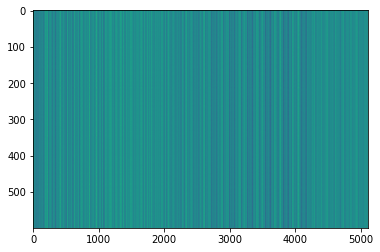

,AUC,pAUC
Source_0,0.707700,0.584737
Source_1,0.575500,0.522105
Source_2,0.738000,0.640526
Target_0,0.664000,0.631579
Target_1,0.605200,0.501579
Target_2,0.617500,0.525789
mean,0.651317,0.567719
h_mean,0.646310,0.562554


2021-06-01 14:22:41,302 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:1167.853129, val_AUC_hmean:0.646310, val_pAUC_hmean:0.562554, best_flag:True
2021-06-01 14:22:41,302 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.42it/s]
2021-06-01 14:22:42,355 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.52it/s]
2021-06-01 14:22:42,410 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.45it/s]
2021-06-01 14:22:42,481 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:1092.697113, val_AUC_hmean:0.672736, val_pAUC_hmean:0.553880, best_flag:False
2021-06-01 14:22:42,482 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.56it/s]
2021-06-01 14:22:43,522 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.08it/s]
2021-06-01 14:22:43,587 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.64it/s]
2021-06-01 14:22:

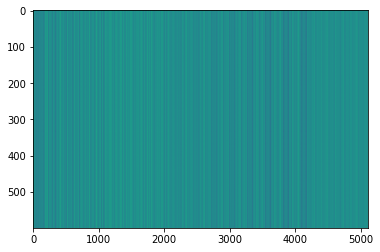

,AUC,pAUC
Source_0,0.747000,0.593158
Source_1,0.648100,0.513684
Source_2,0.817000,0.672632
Target_0,0.733100,0.635789
Target_1,0.589000,0.506842
Target_2,0.625100,0.503684
mean,0.693217,0.570965
h_mean,0.684365,0.563352


2021-06-01 14:22:48,926 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:981.901449, val_AUC_hmean:0.684365, val_pAUC_hmean:0.563352, best_flag:True
2021-06-01 14:22:48,927 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.43it/s]
2021-06-01 14:22:49,978 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 53.23it/s]
2021-06-01 14:22:50,040 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 61.16it/s]


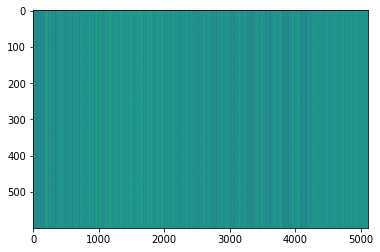

,AUC,pAUC
Source_0,0.714300,0.590000
Source_1,0.606800,0.526842
Source_2,0.827300,0.677368
Target_0,0.750200,0.645789
Target_1,0.602000,0.543158
Target_2,0.580900,0.486842
mean,0.680250,0.578333
h_mean,0.668726,0.570725


2021-06-01 14:22:53,045 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:952.265483, val_AUC_hmean:0.668726, val_pAUC_hmean:0.570725, best_flag:True
2021-06-01 14:22:53,046 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.27it/s]
2021-06-01 14:22:54,114 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.59it/s]
2021-06-01 14:22:54,170 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.88it/s]


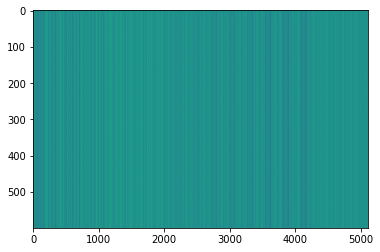

,AUC,pAUC
Source_0,0.759300,0.611053
Source_1,0.658300,0.530000
Source_2,0.805900,0.681053
Target_0,0.748500,0.638947
Target_1,0.615800,0.522632
Target_2,0.626800,0.511579
mean,0.702433,0.582544
h_mean,0.695070,0.575549


2021-06-01 14:22:57,166 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:930.873683, val_AUC_hmean:0.695070, val_pAUC_hmean:0.575549, best_flag:True
2021-06-01 14:22:57,167 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.32it/s]
2021-06-01 14:22:58,229 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.78it/s]
2021-06-01 14:22:58,282 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.14it/s]
2021-06-01 14:22:58,356 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:912.132797, val_AUC_hmean:0.691085, val_pAUC_hmean:0.572339, best_flag:False
2021-06-01 14:22:58,358 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.58it/s]
2021-06-01 14:22:59,396 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.19it/s]
2021-06-01 14:22:59,453 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 58.66it/s]
2021-06-01 14:22:

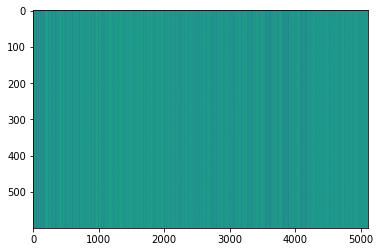

,AUC,pAUC
Source_0,0.740600,0.602632
Source_1,0.685400,0.525263
Source_2,0.816500,0.696842
Target_0,0.764000,0.669474
Target_1,0.625900,0.561053
Target_2,0.600000,0.505789
mean,0.705400,0.593509
h_mean,0.697086,0.585285


2021-06-01 14:23:03,625 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:886.284449, val_AUC_hmean:0.697086, val_pAUC_hmean:0.585285, best_flag:True
2021-06-01 14:23:03,626 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.32it/s]
2021-06-01 14:23:04,790 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.87it/s]
2021-06-01 14:23:04,848 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.46it/s]
2021-06-01 14:23:04,911 - pytorch_modeler.py - INFO - epoch:14/100, train_losses:866.860224, val_AUC_hmean:0.689461, val_pAUC_hmean:0.578275, best_flag:False
2021-06-01 14:23:04,913 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.50it/s]
2021-06-01 14:23:05,959 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 54.08it/s]
2021-06-01 14:23:06,021 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.69it/s]
2021-06-01 14:23:

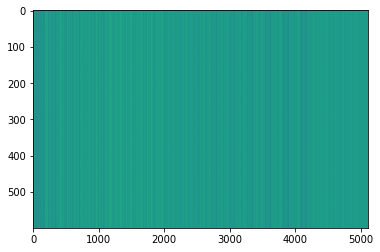

,AUC,pAUC
Source_0,0.728600,0.597895
Source_1,0.664800,0.537895
Source_2,0.825900,0.687368
Target_0,0.774100,0.692105
Target_1,0.631600,0.550526
Target_2,0.586700,0.505263
mean,0.701950,0.595175
h_mean,0.692276,0.586686


2021-06-01 14:23:14,010 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:814.584595, val_AUC_hmean:0.692276, val_pAUC_hmean:0.586686, best_flag:True
2021-06-01 14:23:14,011 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.35it/s]
2021-06-01 14:23:15,070 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.66it/s]
2021-06-01 14:23:15,128 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 66.24it/s]
2021-06-01 14:23:15,185 - pytorch_modeler.py - INFO - epoch:20/100, train_losses:808.291255, val_AUC_hmean:0.697666, val_pAUC_hmean:0.577633, best_flag:False
2021-06-01 14:23:15,186 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.48it/s]
2021-06-01 14:23:16,234 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.91it/s]
2021-06-01 14:23:16,298 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.78it/s]
2021-06-01 14:23:

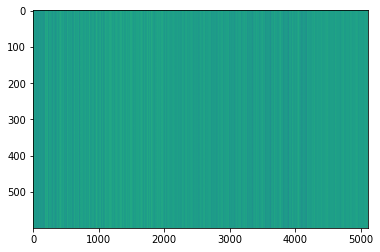

,AUC,pAUC
Source_0,0.751700,0.623684
Source_1,0.693000,0.516842
Source_2,0.849500,0.728947
Target_0,0.771000,0.671579
Target_1,0.668500,0.601579
Target_2,0.621400,0.508947
mean,0.725850,0.608596
h_mean,0.718334,0.598432


2021-06-01 14:23:24,348 - pytorch_modeler.py - INFO - epoch:25/100, train_losses:762.157822, val_AUC_hmean:0.718334, val_pAUC_hmean:0.598432, best_flag:True
2021-06-01 14:23:24,349 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.57it/s]
2021-06-01 14:23:25,388 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.06it/s]
2021-06-01 14:23:25,448 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 66.37it/s]
2021-06-01 14:23:25,507 - pytorch_modeler.py - INFO - epoch:26/100, train_losses:758.147242, val_AUC_hmean:0.698299, val_pAUC_hmean:0.583380, best_flag:False
2021-06-01 14:23:25,509 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.64it/s]
2021-06-01 14:23:26,541 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.88it/s]
2021-06-01 14:23:26,593 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 61.14it/s]
2021-06-01 14:23:

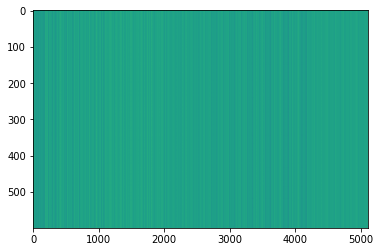

,AUC,pAUC
Source_0,0.721400,0.623684
Source_1,0.693300,0.537895
Source_2,0.817800,0.709474
Target_0,0.741700,0.674737
Target_1,0.668800,0.585789
Target_2,0.622300,0.513158
mean,0.710883,0.607456
h_mean,0.705735,0.599410


2021-06-01 14:23:40,155 - pytorch_modeler.py - INFO - epoch:36/100, train_losses:693.917236, val_AUC_hmean:0.705735, val_pAUC_hmean:0.599410, best_flag:True
2021-06-01 14:23:40,156 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.33it/s]
2021-06-01 14:23:41,218 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.16it/s]
2021-06-01 14:23:41,272 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.93it/s]
2021-06-01 14:23:41,342 - pytorch_modeler.py - INFO - epoch:37/100, train_losses:688.185374, val_AUC_hmean:0.693080, val_pAUC_hmean:0.580860, best_flag:False
2021-06-01 14:23:41,343 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.60it/s]
2021-06-01 14:23:42,379 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 54.52it/s]
2021-06-01 14:23:42,444 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.12it/s]
2021-06-01 14:23:

100%|██████████| 2/2 [00:00<00:00, 49.47it/s]
2021-06-01 14:24:00,079 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.13it/s]
2021-06-01 14:24:00,138 - pytorch_modeler.py - INFO - epoch:53/100, train_losses:609.846375, val_AUC_hmean:0.699755, val_pAUC_hmean:0.592899, best_flag:False
2021-06-01 14:24:00,140 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.66it/s]
2021-06-01 14:24:01,170 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.69it/s]
2021-06-01 14:24:01,230 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.49it/s]
2021-06-01 14:24:01,300 - pytorch_modeler.py - INFO - epoch:54/100, train_losses:607.273239, val_AUC_hmean:0.692929, val_pAUC_hmean:0.582179, best_flag:False
2021-06-01 14:24:01,301 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.60it/s]
2021-06-01 14:24:02,338 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:01<00:00, 11.61it/s]
2021-06-01 14:24:19,902 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.31it/s]
2021-06-01 14:24:19,964 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.87it/s]
2021-06-01 14:24:20,029 - pytorch_modeler.py - INFO - epoch:70/100, train_losses:539.630056, val_AUC_hmean:0.693862, val_pAUC_hmean:0.587691, best_flag:False
2021-06-01 14:24:20,030 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.52it/s]
2021-06-01 14:24:21,073 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.80it/s]
2021-06-01 14:24:21,133 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.64it/s]
2021-06-01 14:24:21,198 - pytorch_modeler.py - INFO - epoch:71/100, train_losses:535.877513, val_AUC_hmean:0.704176, val_pAUC_hmean:0.591257, best_flag:False
2021-06-01 14:24:21,199 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-06-01 14:24:38,771 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.67it/s]
2021-06-01 14:24:39,801 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.80it/s]
2021-06-01 14:24:39,857 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 58.52it/s]
2021-06-01 14:24:39,917 - pytorch_modeler.py - INFO - epoch:87/100, train_losses:478.298144, val_AUC_hmean:0.697086, val_pAUC_hmean:0.585056, best_flag:False
2021-06-01 14:24:39,918 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.63it/s]
2021-06-01 14:24:40,951 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.47it/s]
2021-06-01 14:24:41,010 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.60it/s]
2021-06-01 14:24:41,075 - pytorch_modeler.py - INFO - epoch:88/100, train_losses:473.684687, val_AUC_hmean:0.701605, val_pAUC_hmean:0.589770, best_flag:False
2021-06-01 14:24

,AUC,pAUC
Source_0,0.721400,0.623684
Source_1,0.693300,0.537895
Source_2,0.817800,0.709474
Target_0,0.741700,0.674737
Target_1,0.668800,0.585789
Target_2,0.622300,0.513158
mean,0.710883,0.607456
h_mean,0.705735,0.599410


2021-06-01 14:24:55,249 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-06-01 14:24:55,249 - 00_train.py - INFO - MAKE DATA_LOADER
2021-06-01 14:24:55,251 - 00_train.py - INFO - TRAINING


elapsed time: 145.157485247 [sec]


2021-06-01 14:24:56,065 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.49it/s]
2021-06-01 14:24:57,111 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.84it/s]
2021-06-01 14:24:57,170 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.88it/s]


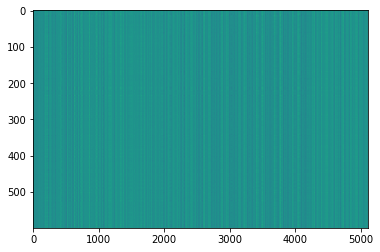

,AUC,pAUC
Source_0,0.647100,0.566842
Source_1,0.490100,0.490526
Source_2,0.636800,0.614211
Target_0,0.640800,0.604211
Target_1,0.609700,0.504211
Target_2,0.599400,0.516316
mean,0.603983,0.549386
h_mean,0.598495,0.545155


2021-06-01 14:25:00,068 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:2526.323873, val_AUC_hmean:0.598495, val_pAUC_hmean:0.545155, best_flag:True
2021-06-01 14:25:00,069 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.59it/s]
2021-06-01 14:25:01,106 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.34it/s]
2021-06-01 14:25:01,164 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.22it/s]
2021-06-01 14:25:01,235 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1623.669281, val_AUC_hmean:0.617540, val_pAUC_hmean:0.533354, best_flag:False
2021-06-01 14:25:01,236 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.68it/s]
2021-06-01 14:25:02,265 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.72it/s]
2021-06-01 14:25:02,321 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.26it/s]


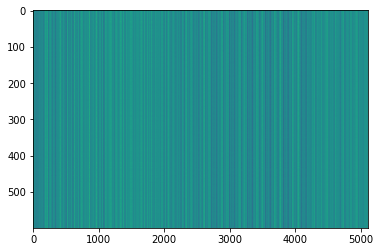

,AUC,pAUC
Source_0,0.759300,0.577368
Source_1,0.590000,0.510000
Source_2,0.729400,0.638421
Target_0,0.698600,0.601053
Target_1,0.651000,0.540000
Target_2,0.491200,0.514737
mean,0.653250,0.563596
h_mean,0.639232,0.559833


2021-06-01 14:25:05,258 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:1308.664490, val_AUC_hmean:0.639232, val_pAUC_hmean:0.559833, best_flag:True
2021-06-01 14:25:05,259 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.21it/s]
2021-06-01 14:25:06,332 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 63.22it/s]
2021-06-01 14:25:06,384 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.19it/s]
2021-06-01 14:25:06,449 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:1172.982086, val_AUC_hmean:0.647845, val_pAUC_hmean:0.557917, best_flag:False
2021-06-01 14:25:06,450 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.64it/s]
2021-06-01 14:25:07,483 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.28it/s]
2021-06-01 14:25:07,540 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.93it/s]


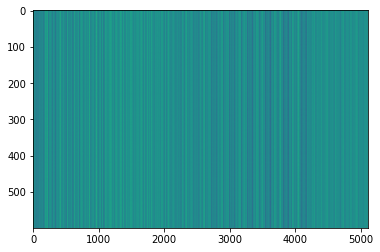

,AUC,pAUC
Source_0,0.764200,0.574211
Source_1,0.612900,0.509474
Source_2,0.781700,0.668947
Target_0,0.729600,0.625789
Target_1,0.611000,0.526842
Target_2,0.599400,0.512105
mean,0.683133,0.569561
h_mean,0.674535,0.563485


2021-06-01 14:25:10,480 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:1106.249573, val_AUC_hmean:0.674535, val_pAUC_hmean:0.563485, best_flag:True
2021-06-01 14:25:10,481 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.20it/s]
2021-06-01 14:25:11,555 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 55.88it/s]
2021-06-01 14:25:11,618 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.80it/s]
2021-06-01 14:25:11,692 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:1047.668844, val_AUC_hmean:0.670622, val_pAUC_hmean:0.558951, best_flag:False
2021-06-01 14:25:11,693 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.69it/s]
2021-06-01 14:25:12,721 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 63.99it/s]
2021-06-01 14:25:12,772 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 63.78it/s]
2021-06-01 14:25:

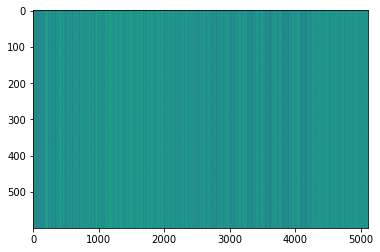

,AUC,pAUC
Source_0,0.760000,0.584737
Source_1,0.671300,0.526842
Source_2,0.813700,0.680526
Target_0,0.773600,0.653684
Target_1,0.623100,0.558947
Target_2,0.620600,0.506842
mean,0.710383,0.585263
h_mean,0.702307,0.578615


2021-06-01 14:25:18,134 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:954.324209, val_AUC_hmean:0.702307, val_pAUC_hmean:0.578615, best_flag:True
2021-06-01 14:25:18,135 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.46it/s]
2021-06-01 14:25:19,184 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.43it/s]
2021-06-01 14:25:19,240 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 60.50it/s]
2021-06-01 14:25:19,302 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:934.905853, val_AUC_hmean:0.684274, val_pAUC_hmean:0.561712, best_flag:False
2021-06-01 14:25:19,303 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.67it/s]
2021-06-01 14:25:20,333 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.85it/s]
2021-06-01 14:25:20,388 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.40it/s]


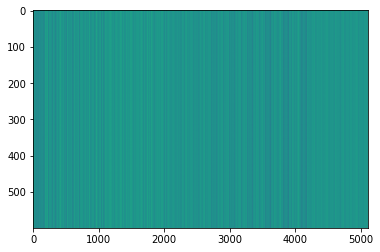

,AUC,pAUC
Source_0,0.756100,0.622632
Source_1,0.643300,0.521053
Source_2,0.800100,0.691053
Target_0,0.737400,0.669474
Target_1,0.593500,0.522105
Target_2,0.665000,0.515263
mean,0.699233,0.590263
h_mean,0.691906,0.581275


2021-06-01 14:25:23,370 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:915.966268, val_AUC_hmean:0.691906, val_pAUC_hmean:0.581275, best_flag:True
2021-06-01 14:25:23,371 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.63it/s]
2021-06-01 14:25:24,405 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.33it/s]
2021-06-01 14:25:24,462 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 34.06it/s]


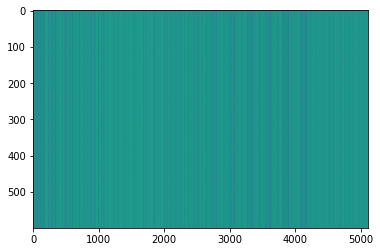

,AUC,pAUC
Source_0,0.778800,0.621053
Source_1,0.686200,0.524737
Source_2,0.830800,0.690000
Target_0,0.772300,0.666316
Target_1,0.620400,0.539474
Target_2,0.652400,0.501579
mean,0.723483,0.590526
h_mean,0.715607,0.581772


2021-06-01 14:25:27,480 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:903.927862, val_AUC_hmean:0.715607, val_pAUC_hmean:0.581772, best_flag:True
2021-06-01 14:25:27,481 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.05it/s]
2021-06-01 14:25:28,569 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.72it/s]
2021-06-01 14:25:28,638 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 58.66it/s]
2021-06-01 14:25:28,705 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:893.411697, val_AUC_hmean:0.696519, val_pAUC_hmean:0.571743, best_flag:False
2021-06-01 14:25:28,706 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.22it/s]
2021-06-01 14:25:29,779 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 53.47it/s]
2021-06-01 14:25:29,847 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.32it/s]
2021-06-01 14:25:

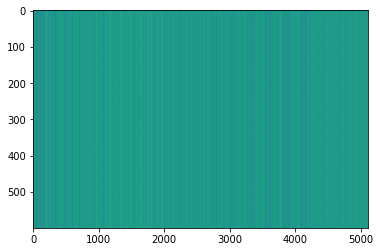

,AUC,pAUC
Source_0,0.735800,0.622105
Source_1,0.693300,0.517895
Source_2,0.848900,0.728421
Target_0,0.750600,0.665263
Target_1,0.660100,0.564737
Target_2,0.625500,0.496842
mean,0.719033,0.599211
h_mean,0.712137,0.588363


2021-06-01 14:25:37,601 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:827.690297, val_AUC_hmean:0.712137, val_pAUC_hmean:0.588363, best_flag:True
2021-06-01 14:25:37,602 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.56it/s]
2021-06-01 14:25:38,642 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.78it/s]
2021-06-01 14:25:38,697 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.19it/s]


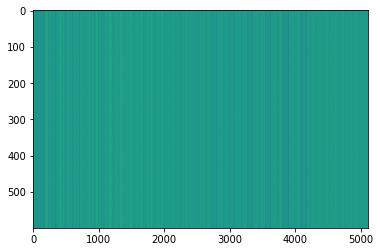

,AUC,pAUC
Source_0,0.765400,0.605263
Source_1,0.670900,0.533684
Source_2,0.809700,0.715263
Target_0,0.798000,0.690000
Target_1,0.666600,0.572105
Target_2,0.595700,0.518947
mean,0.717717,0.605877
h_mean,0.708881,0.597121


2021-06-01 14:25:41,700 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:821.222082, val_AUC_hmean:0.708881, val_pAUC_hmean:0.597121, best_flag:True
2021-06-01 14:25:41,701 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.55it/s]
2021-06-01 14:25:42,743 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.11it/s]
2021-06-01 14:25:42,917 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.29it/s]
2021-06-01 14:25:42,980 - pytorch_modeler.py - INFO - epoch:20/100, train_losses:813.522242, val_AUC_hmean:0.697843, val_pAUC_hmean:0.578026, best_flag:False
2021-06-01 14:25:42,981 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.55it/s]
2021-06-01 14:25:44,022 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.14it/s]
2021-06-01 14:25:44,082 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.28it/s]
2021-06-01 14:25:

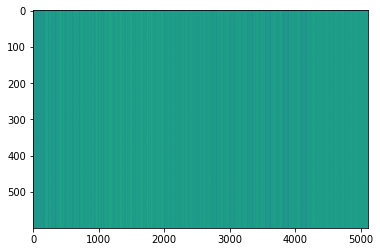

,AUC,pAUC
Source_0,0.777200,0.631579
Source_1,0.696200,0.523158
Source_2,0.851000,0.741579
Target_0,0.771800,0.668947
Target_1,0.686700,0.586842
Target_2,0.604600,0.499474
mean,0.731250,0.608596
h_mean,0.722541,0.597353


2021-06-01 14:25:49,349 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:786.085098, val_AUC_hmean:0.722541, val_pAUC_hmean:0.597353, best_flag:True
2021-06-01 14:25:49,350 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.34it/s]
2021-06-01 14:25:50,410 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.18it/s]
2021-06-01 14:25:50,468 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.09it/s]
2021-06-01 14:25:50,532 - pytorch_modeler.py - INFO - epoch:24/100, train_losses:777.671829, val_AUC_hmean:0.702526, val_pAUC_hmean:0.582504, best_flag:False
2021-06-01 14:25:50,533 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.57it/s]
2021-06-01 14:25:51,573 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.07it/s]
2021-06-01 14:25:51,629 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.89it/s]
2021-06-01 14:25:

100%|██████████| 2/2 [00:00<00:00, 58.60it/s]
2021-06-01 14:26:09,528 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.74it/s]
2021-06-01 14:26:09,596 - pytorch_modeler.py - INFO - epoch:40/100, train_losses:679.300329, val_AUC_hmean:0.705464, val_pAUC_hmean:0.588168, best_flag:False
2021-06-01 14:26:09,597 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.49it/s]
2021-06-01 14:26:10,643 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 27.55it/s]
2021-06-01 14:26:10,739 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.53it/s]
2021-06-01 14:26:10,800 - pytorch_modeler.py - INFO - epoch:41/100, train_losses:673.350032, val_AUC_hmean:0.713629, val_pAUC_hmean:0.595935, best_flag:False
2021-06-01 14:26:10,801 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.94it/s]
2021-06-01 14:26:11,902 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

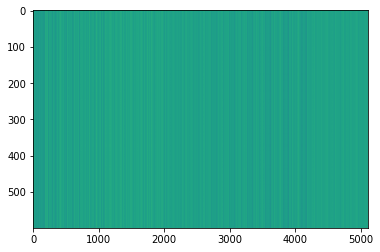

,AUC,pAUC
Source_0,0.761700,0.639474
Source_1,0.694500,0.534737
Source_2,0.854300,0.740000
Target_0,0.774500,0.681579
Target_1,0.669000,0.567368
Target_2,0.623000,0.499474
mean,0.729500,0.610439
h_mean,0.721644,0.598980


2021-06-01 14:26:14,989 - pytorch_modeler.py - INFO - epoch:42/100, train_losses:666.791565, val_AUC_hmean:0.721644, val_pAUC_hmean:0.598980, best_flag:True
2021-06-01 14:26:14,990 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.15it/s]
2021-06-01 14:26:16,069 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.96it/s]
2021-06-01 14:26:16,122 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 66.66it/s]
2021-06-01 14:26:16,175 - pytorch_modeler.py - INFO - epoch:43/100, train_losses:661.875799, val_AUC_hmean:0.710816, val_pAUC_hmean:0.597045, best_flag:False
2021-06-01 14:26:16,176 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.97it/s]
2021-06-01 14:26:17,180 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 66.33it/s]
2021-06-01 14:26:17,230 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 66.43it/s]
2021-06-01 14:26:

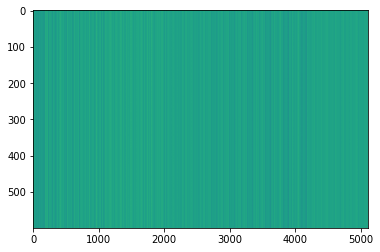

,AUC,pAUC
Source_0,0.770500,0.635263
Source_1,0.663100,0.531053
Source_2,0.846000,0.724211
Target_0,0.772700,0.692105
Target_1,0.664600,0.576842
Target_2,0.599300,0.500000
mean,0.719367,0.609912
h_mean,0.709606,0.599014


2021-06-01 14:26:23,745 - pytorch_modeler.py - INFO - epoch:47/100, train_losses:642.833598, val_AUC_hmean:0.709606, val_pAUC_hmean:0.599014, best_flag:True
2021-06-01 14:26:23,746 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.55it/s]
2021-06-01 14:26:24,787 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 65.83it/s]
2021-06-01 14:26:24,837 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 66.98it/s]
2021-06-01 14:26:24,890 - pytorch_modeler.py - INFO - epoch:48/100, train_losses:636.014933, val_AUC_hmean:0.710729, val_pAUC_hmean:0.596013, best_flag:False
2021-06-01 14:26:24,891 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.96it/s]
2021-06-01 14:26:25,896 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 67.59it/s]
2021-06-01 14:26:25,946 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 67.12it/s]
2021-06-01 14:26:

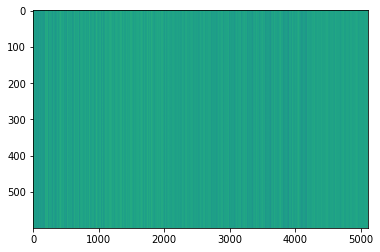

,AUC,pAUC
Source_0,0.763300,0.642632
Source_1,0.678100,0.528421
Source_2,0.864300,0.743684
Target_0,0.769500,0.690000
Target_1,0.659600,0.578421
Target_2,0.580600,0.496316
mean,0.719233,0.613246
h_mean,0.707565,0.600832


2021-06-01 14:26:37,977 - pytorch_modeler.py - INFO - epoch:57/100, train_losses:599.341268, val_AUC_hmean:0.707565, val_pAUC_hmean:0.600832, best_flag:True
2021-06-01 14:26:37,978 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.86it/s]
2021-06-01 14:26:38,991 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 65.05it/s]
2021-06-01 14:26:39,042 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 67.31it/s]
2021-06-01 14:26:39,095 - pytorch_modeler.py - INFO - epoch:58/100, train_losses:592.819412, val_AUC_hmean:0.714850, val_pAUC_hmean:0.596044, best_flag:False
2021-06-01 14:26:39,096 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.44it/s]
2021-06-01 14:26:40,147 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 29.89it/s]
2021-06-01 14:26:40,247 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 61.99it/s]
2021-06-01 14:26:

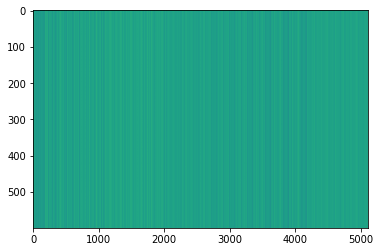

,AUC,pAUC
Source_0,0.762400,0.641053
Source_1,0.690900,0.537895
Source_2,0.848700,0.735789
Target_0,0.766700,0.694211
Target_1,0.673500,0.590000
Target_2,0.603500,0.503158
mean,0.724283,0.617018
h_mean,0.715702,0.606001


2021-06-01 14:26:52,723 - pytorch_modeler.py - INFO - epoch:67/100, train_losses:556.685776, val_AUC_hmean:0.715702, val_pAUC_hmean:0.606001, best_flag:True
2021-06-01 14:26:52,724 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.44it/s]
2021-06-01 14:26:53,775 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 67.48it/s]
2021-06-01 14:26:53,824 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
2021-06-01 14:26:53,876 - pytorch_modeler.py - INFO - epoch:68/100, train_losses:552.058848, val_AUC_hmean:0.713820, val_pAUC_hmean:0.597144, best_flag:False
2021-06-01 14:26:53,878 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.96it/s]
2021-06-01 14:26:54,883 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 66.36it/s]
2021-06-01 14:26:54,934 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 66.99it/s]
2021-06-01 14:26:

100%|██████████| 2/2 [00:00<00:00, 47.96it/s]
2021-06-01 14:27:12,042 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.08it/s]
2021-06-01 14:27:12,113 - pytorch_modeler.py - INFO - epoch:84/100, train_losses:494.309970, val_AUC_hmean:0.698135, val_pAUC_hmean:0.594044, best_flag:False
2021-06-01 14:27:12,114 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.37it/s]
2021-06-01 14:27:13,172 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 54.02it/s]
2021-06-01 14:27:13,235 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.66it/s]
2021-06-01 14:27:13,310 - pytorch_modeler.py - INFO - epoch:85/100, train_losses:489.422796, val_AUC_hmean:0.698496, val_pAUC_hmean:0.592235, best_flag:False
2021-06-01 14:27:13,311 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.96it/s]
2021-06-01 14:27:14,408 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

,AUC,pAUC
Source_0,0.762400,0.641053
Source_1,0.690900,0.537895
Source_2,0.848700,0.735789
Target_0,0.766700,0.694211
Target_1,0.673500,0.590000
Target_2,0.603500,0.503158
mean,0.724283,0.617018
h_mean,0.715702,0.606001


elapsed time: 156.406069756 [sec]


In [15]:
for machine_type in machine_types:
    run(machine_type)

In [16]:
#run(machine_types[2])